# Clustering: Using the City of Toronto's Open Data to Analyze Councillor Voting Behaviour

### by Mark M<sup>c</sup>Carthy

I find myself in a position where my previous work is proprietary to my former employers, and I don't have much of a publicly available portfolio. To fix this, I wanted to find a sizeable public dataset then perform a non-trivial analysis, and to have **fun** doing it! In this project I used attendance data from the city councils of Toronto to study councillor absenteeism, and you can read about this in [another notebook](https://github.com/markomemos/councillors/blob/master/councillor_attendance.ipynb). I later wrote a clustering algorithm to group councillors based their voting records, developed it with Toronto data and evaluated it with Calgary data, and you can see the analysis below. 

The clustering algorithm was a heirarchichal agglomerative weight-based non-euclidean clustering using the sum of the variances in the clusters as the objective function to be minimized. A complex imputation was also performed on sparse, non-euclidean data with highly non-uniform uncertainties, with the intent of optimizing the result of the clustering to come.

Many municipalities have open source data available on a very wide number of topics. For example, in Toronto you can find data on everything from all public city-provided wifi, to red-light camera locations, to restaurant food inspection results. Here are the data for [Toronto](https://open.toronto.ca/) and [Calgary](https://data.calgary.ca/).

## Councillor clustering based on voting behaviour

Now that we've grown comfortable with the open data, let's see if we can do something more sophisticated. If we look at voting records rather than just attendance records, we can try to group councillors together based on how similar they are from each other. To see if we've done a good job clustering, I built everything that follows using the Toronto council voting data. When I was satisfied that the results looked reasonable, I tested to see if it worked using the Calgary council voting data.<br>

Unfortunately we see that there is a substantial difference between the two datasets. Toronto's voting records go back to 2006, whereas Calgary's only go back to 2017. To go back further with Calgary's data, it looks like I'd have to do some pdf scraping of the meeting minutes. Since this is supposed to be a ***fun*** project, I'll just let it be. If I were to do this again, I'd try to find a better train-validation-test breakdown.

---

Here is our roadmap for what is to come:
1. Data ingestion: filtering and processing
2. Compute dissimilarity matrix
3. Impute missing values in dissimilarity matrix
4. Cluster

---

### Data ingestion: filtering and processing

First we need to import our modules. Given the scale of this project, pandas seems to be an appropriate choice

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import os
print('pandas version = '+pd.__version__)
print('numpy version = '+np.__version__)
print('networkx version = '+nx.__version__)

pandas version = 2.0.3
numpy version = 1.24.3
networkx version = 3.1


Next we load our data. I've decided to duplicate all our dataframes into two sets, a Toronto set and a Calgary set. Had this been a bigger project, I'd love to turn all these into function calls or some kind of sklearn pipelines, but that's beyond the scope for now.

In [2]:
# Let's label our two datasets, in case I forget my naming scheme
city_dict = {0:'Toronto',1:'Calgary'}

# Don't judge my pathname!
dir_name = '/Users/markmccarthy/Documents/coding_fun/toronto_dsci/councillors/data/'
filenames = {}

# Toronto data 
short_filenames = [
    'member-voting-record-2022-2026.csv',
    'member-voting-record-2018-2022.csv',
    'member-voting-record-2014-2018.csv',
    'member-voting-record-2010-2014.csv',
    'member-voting-record-2006-2010.csv'
]
filenames[0] = [dir_name + f for f in short_filenames] 

# Calgary data
filenames[1] = [dir_name + 'Council_and_Committee_Votes_20231024.csv']

In [3]:
raw_voting_df = {}

# Toronto
raw_voting_df[0] = pd.concat((pd.read_csv(f, index_col = '_id') for f in filenames[0]), ignore_index=True)

#Calgary
raw_voting_df[1] = pd.read_csv(filenames[1][0])

In [4]:
# Get a sense of what the data looks like
for city_id, df in raw_voting_df.items():
    print(f'City = {city_dict[city_id]}')
    display(df.head())
    display(df.describe(include='all'))
    print(' ')

City = Toronto


Term First Name Last Name     Committee Date/Time Agenda Item #  \
0  2022-2026       Paul   Ainslie  City Council       NaN    2023.FM1.8   
1  2022-2026       Brad  Bradford  City Council       NaN    2023.FM1.8   
2  2022-2026  Alejandra     Bravo  City Council       NaN    2023.FM1.8   
3  2022-2026        Jon  Burnside  City Council       NaN    2023.FM1.8   
4  2022-2026    Shelley   Carroll  City Council       NaN    2023.FM1.8   

                            Agenda Item Title             Motion Type Vote  \
0  Election of the Speaker and Deputy Speaker  Nomination of a Member  Yes   
1  Election of the Speaker and Deputy Speaker  Nomination of a Member  Yes   
2  Election of the Speaker and Deputy Speaker  Nomination of a Member  Yes   
3  Election of the Speaker and Deputy Speaker  Nomination of a Member  Yes   
4  Election of the Speaker and Deputy Speaker  Nomination of a Member  Yes   

          Result                                   Vote Description  
0  Carried, 25-1  Majority required - Appoint Councillor Nunziat...  
1  Carried, 25-1  Majority required - Appoint Councillor Nunziat...  
2  Carried, 25-1  Majority required - Appoint Councillor Nunziat...  
3  Carried, 25-1  Majority required - Appoint Councillor Nunziat...  
4  Carried, 25-1  Majority required - Appoint Councillor Nunziat...

Term First Name Last Name     Committee            Date/Time  \
count      707546     707546    707546        707546                28840   
unique          5         74        87            57                  784   
top     2010-2014       John      Ford  City Council  2010-03-09T00:00:00   
freq       358814      37559     23840        683450                 1118   

       Agenda Item #                                  Agenda Item Title  \
count         707546                                             707546   
unique          8576                                               7718   
top      2011.EX10.1  Introduction and Enactment of General Bills an...   
freq            4545                                              31696   

       Motion Type    Vote         Result   Vote Description  
count       707546  707546         707546             707546  
unique          52       3           1027              15456  
top     Adopt Item     Yes  Carried, 39-0  Majority required  
freq        167403  507330          19626              16363

 
City = Calgary


MeetingType MeetingDate  \
0  Audit Committee  2022/01/20   
1  Audit Committee  2022/01/20   
2  Audit Committee  2022/01/20   
3  Audit Committee  2022/01/20   
4  Audit Committee  2022/01/20   

                                          Resolution                    Voter  \
0  That with respect to Report AC2022-0042, the f...         Lori Caltagirone   
1  That with respect to Report AC2022-0042, the f...                Karen Kim   
2  That with respect to Report AC2022-0042, the f...  John (Richard) Pootmans   
3  That with respect to Report AC2022-0042, the f...          Jennifer Wyness   
4  That with respect to Report AC2022-0042, the f...               Terry Wong   

  Vote          Result  
0  Yes  MOTION CARRIED  
1  Yes  MOTION CARRIED  
2  Yes  MOTION CARRIED  
3  Yes  MOTION CARRIED  
4  Yes  MOTION CARRIED

MeetingType MeetingDate  \
count                         28255       28255   
unique                           13         187   
top     Combined Meeting of Council  2022/03/29   
freq                          15861        1336   

                                               Resolution     Voter   Vote  \
count                                               28255     28255  28255   
unique                                               2312        51      3   
top     That Recommendation 1 contained in Report C202...  Sean Chu    Yes   
freq                                                   30      1659  25348   

                Result  
count            28255  
unique               2  
top     MOTION CARRIED  
freq             26825

In [5]:
# Check for duplicated data
for city_id, df in raw_voting_df.items():
    print(f'City = {city_dict[city_id]}')
    print(f'Number of duplicated rows = {df[df.duplicated()].shape[0]}')
    print(' ') # could use more whitespace

City = Toronto
Number of duplicated rows = 2037
 
City = Calgary
Number of duplicated rows = 1411
 


In [6]:
# Check for missing data
for city_id, df in raw_voting_df.items():
    print(f'City = {city_dict[city_id]}')
    display(df.isnull().sum().to_frame().rename(columns={0:'Nulls'}))
    print(' ') # could use more whitespace

City = Toronto


Nulls
Term                    0
First Name              0
Last Name               0
Committee               0
Date/Time          678706
Agenda Item #           0
Agenda Item Title       0
Motion Type             0
Vote                    0
Result                  0
Vote Description        0

 
City = Calgary


Nulls
MeetingType      0
MeetingDate      0
Resolution       0
Voter            0
Vote             0
Result           0

We can see that the Toronto and Calgary data have a lot in common. Both have varied `Committee` or `MeetingType` including council votes and committee votes, and each row represents each councillor at each vote. We can already see some features of the data, for example, the Toronto `Date/Time` column is mostly empty, so we should be careful if ever using it.

---

Now let's dive into the peculiarities of our data and compile a list of clean-up actions we'll need to perform later:

In [7]:
for city_id, df in raw_voting_df.items():
    print(f'City = {city_dict[city_id]}')
    # it's quite convenient that the column name 'Vote' appears in both datasets!
    display(df.Vote.value_counts().to_frame())
    print(' ')

City = Toronto


count
Vote          
Yes     507330
Absent  108378
No       91838

 
City = Calgary


count
Vote         
Yes     25348
No       2897
Absent     10

One major difference between the datasets is apparent here... In Toronto absent councillors are always given a row in the data where they `Vote` `Absent`, whereas the absent councillors in Calgary are omitted from the table entirely, with rare exceptions.<br><br>
This feature lets us quickly redo our attendance analysis in Toronto quite easily, but on a per-vote rather than per-meeting basis! To do so in Calgary, however, would require ingesting some new data that tells us who was a councillor and when. We could then impute the `Absent`s ourselves, but there may be many situations where councillors are not on a committee or otherwise not eligible to vote, which could cause problems.<br><br>
So, for now, let's try to quickly redo our attendance analysis on a per-vote basis and see if we get similar results!

In [8]:
# Check which councillors missed votes, Toronto only
voting_attend_df = raw_voting_df[0].copy()

# Get rid of committee votes 
voting_attend_df = voting_attend_df.loc[voting_attend_df['Committee'] == 'City Council']

# Group the names into one column (this isn't strictly necessary)
voting_attend_df['Name'] = voting_attend_df['First Name'] + ' ' + voting_attend_df['Last Name']
voting_attend_df = voting_attend_df.drop(columns = ['First Name','Last Name'])

# Group by councillor and get the percentage of absent votes
voting_attend_df['Absent'] = np.where(voting_attend_df['Vote']=='Absent', 1, 0)
voting_attend_df = voting_attend_df.groupby('Name')['Absent'].agg(['count', 'sum'])
voting_attend_df['AbsentPercent'] = 100 * voting_attend_df['sum'] / voting_attend_df['count']
voting_attend_df = voting_attend_df.rename(columns={'count': 'EligibleVotes', 'sum': 'TimesAbsent'}).reset_index()

# Remove councillors with a low vote count
# There are probably better choices for a cut-off, but the 25th percentile is at least consistent with the previous analysis
print('The distribution of Eligible Votes before any cuts:')
display(voting_attend_df.EligibleVotes.describe().to_frame())
voting_attend_df = voting_attend_df.loc[voting_attend_df['EligibleVotes'] > voting_attend_df.EligibleVotes.quantile(0.25)]

# Display results
print('Final attendance information based on votes:')
display(voting_attend_df.sort_values(by=['AbsentPercent'],ascending=False))

The distribution of Eligible Votes before any cuts:


EligibleVotes
count      92.000000
mean     7428.804348
std      5991.806140
min         4.000000
25%      1382.000000
50%      6722.000000
75%     13737.000000
max     16359.000000

Final attendance information based on votes:


Name  EligibleVotes  TimesAbsent  AbsentPercent
28  Giorgio Mammoliti          13737         6541      47.615928
84         Ron Moeser          11869         4749      40.011795
66   Michelle Holland           3184         1249      39.227387
23          Doug Ford           7813         2319      29.681300
82           Rob Ford          10655         2800      26.278742
..                ...            ...          ...            ...
79         Peter Leon           2582           70       2.711077
31         Gord Perks          16359          206       1.259246
39           Jim Hart           1633           19       1.163503
24       Doug Holyday           6445           71       1.101629
89    Stephen Holyday           7164            9       0.125628

[62 rows x 4 columns]

Looks good, a lot of the same names show up as before! The per-meeting numbers are probably more meaningful than the per-vote numbers because meeting attendance is more likely to be independent data points, but it's nice to see some relative agreement.<br>
<br>
Next, we can look at one of the remaining unexamined columns in the Toronto data, the `Motion Type`. I can imagine that some motions are controversial, some motions are skippable, and some are good reflections of a candidates viewpoints. Let's see how it breaks down:

In [9]:
# Check which Motion Types are controversial and/or commonly skipped
voting_motion_type_df = raw_voting_df[0].copy()

# Get the total votes of each response grouped by Motion Type
voting_motion_type_df = voting_motion_type_df.groupby('Motion Type').apply(lambda x: pd.Series(dict(
    yes=(x.Vote=='Yes').sum(),
    no=(x.Vote=='No').sum(),
    absent=(x.Vote=='Absent').sum()
)))

# Now let's calculate the secondary numbers
voting_motion_type_df['Total'] = voting_motion_type_df['yes'] + voting_motion_type_df['no'] + voting_motion_type_df['absent']

voting_motion_type_df['Yes %']    = 100 * voting_motion_type_df['yes'] / voting_motion_type_df['Total']
voting_motion_type_df['No %']     = 100 * voting_motion_type_df['no'] / voting_motion_type_df['Total']
voting_motion_type_df['Absent %'] = 100 * voting_motion_type_df['absent'] / voting_motion_type_df['Total']

# Sort by no%... how controversial are these motion types?
display(voting_motion_type_df[['Total','Yes %','No %','Absent %']].sort_values(by='No %', ascending = False))

Total      Yes %       No %   Absent %
Motion Type                                                                   
Adjourn                                    58  25.862069  56.896552  17.241379
Amend Mayor's Proposed Budget             338  44.674556  54.733728   0.591716
Amend Auditor General Workplan            161  44.099379  44.099379  11.801242
Amend Item (Two-Thirds)                   124  51.612903  42.741935   5.645161
Receive Item                             7430  40.740242  38.627187  20.632571
Set Committee Rule                        202  57.425743  33.168317   9.405941
Refer Motion                             2447  55.373927  32.284430  12.341643
Recess                                    306  53.921569  31.045752  15.032680
Meet in Closed Session                     10  60.000000  30.000000  10.000000
Amend Motion                            14162  59.348962  29.939274  10.711764
Remove from Committee                    1880  62.074468  29.308511   8.617021
Refer Item                              10862  52.255570  28.935739  18.808691
Amend Item                             103479  59.842094  27.633626  12.524280
Limit Debate                              360  51.944444  25.555556  22.500000
End Debate                               8968  53.925067  24.498216  21.576717
Extend the Meeting                       6982  57.433400  24.233744  18.332856
Fix Reconvened Meeting                    224  65.178571  24.107143  10.714286
Defer Item Indefinitely                   272  56.617647  23.529412  19.852941
Point of Order                            430  60.465116  23.488372  16.046512
Waive the Rules                           834  57.553957  22.781775  19.664269
Defer Item                               7943  58.642830  21.679466  19.677704
Take Note and File                         52  61.538462  21.153846  17.307692
Add New Business at Committee              66  74.242424  19.696970   6.060606
Amend Item (Additional)                 98525  69.699061  17.849277  12.451662
Waive Referral                          49872  74.370388  16.628569   9.001043
Review Order Paper                         26  61.538462  15.384615  23.076923
Amend the Order Paper                   12598  71.662169  13.549770  14.788062
Extend Debate                            1286  69.440124  13.452566  17.107309
Point of Privilege                        225  64.888889  12.888889  22.222222
Without Recommendations                    72  73.611111  11.111111  15.277778
Reconsider Vote                          3608  78.630820   9.672949  11.696231
Re-open Item                             3735  79.437751   9.638554  10.923695
Reconsider Item                          3362  70.731707   8.120167  21.148126
Waive Notice                             6269  82.788323   7.911948   9.299729
Adopt Item as Amended                   87800  76.504556   6.796128  16.699317
Resolve to Committee of Whole            2843  67.886036   5.276117  26.837847
Withdraw a Motion                        2454  79.095355   4.360228  16.544417
Adopt Item                             167403  79.502757   4.273520  16.223724
Extend Speaking Time                    15435  66.660188   3.699385  29.640428
Introduce Motion without Notice         21456  80.457681   2.614653  16.927666
Introduce and Pass Confirmatory Bill    25852  76.999845   2.394399  20.605756
Introduce and Pass General Bills        13587  75.461839   2.325753  22.212409
Excuse Absentees                         3384  77.925532   2.186761  19.887707
Nomination of a Member                    322  95.341615   2.173913   2.484472
Adopt Order Paper                        4764  75.272880   1.910160  22.816961
Introduce and Pass Bills (Two-thirds)     490  69.795918   1.632653  28.571429
Interim Control By-law                    269  79.553903   1.486989  18.959108
Withdraw an Item                          989  85.338726   1.415571  13.245703
Adopt Order Paper as Amended             4546  86.493621   0.945886  12.560493
Petition Fi

Here we reach a difficult decision... should any motion types be removed because they do not actually reflect councillor voting patterns, which is what we want to observe? You could argue that `Adopt Minutes` and `Introduce Report` are so agreeable that they offer little information about our voters, but it's unclear how to define when a motion is meaningless compared to insightful. Even votes on banal-sounding issues like `Recess` could contain information on the political leanings of councillors, so it's tough to justify removing any of these. Perhaps more importantly, it would be far more difficult to remove similar motions from the Calgary data since this information is obscured within the `Resolution` column, and treating the datasets differently would undermine comparisons between the two. 

In light of this, I've chosen to keep all of our motion types. It's something we can keep in mind if we ever revisit this analysis later.

For fun, what's the most commonly skipped motion? It's `Extend Speaking Time`!

Let's now take a closer look at the Calgary data and see if there is any cleanup required. First we notice some councillor naming inconsistencies:

In [10]:
display(raw_voting_df[1].loc[raw_voting_df[1]['Voter'].str.contains('Gondek')].Voter.value_counts().to_frame())
display(raw_voting_df[1].loc[raw_voting_df[1]['Voter'].str.contains('Pootmans')].Voter.value_counts().to_frame())
display(raw_voting_df[1].loc[raw_voting_df[1]['Voter'].str.contains('Nenshi')].Voter.value_counts().to_frame())

count
Voter                 
Jyoti Gondek       922
Mayor J. Gondek    836

count
Voter                         
John (Richard) Pootmans   1115
Richard Pootmans             2

count
Voter                 
Mayor N. Nenshi    651

The time period of our data spans when Jyoti Gondek was a councillor and when she became mayor. However, she remains just one person, not two, so we need to merge her entries. We should probably also change Naheed Nenshi's name to be consistent with all the councillors. Lastly, we ought to fix those two times that John (Richard) Pootmans' name was entered differently.

One interesting feature of Calgary's municipal government is that there are some committees where private citizens are appointed to the committee and will vote along with some councillors. Since we're not including committee votes anyway, this won't be an issue for our clustering later.

In [11]:
list_of_councillors = raw_voting_df[1].loc[raw_voting_df[1]['MeetingType'].str.contains('Council')].Voter.unique()
display(raw_voting_df[1].loc[raw_voting_df[1]['Voter'].isin(list_of_councillors)==False].MeetingType.value_counts().to_frame())

count
MeetingType                                       
Calgary Planning Commission                   2940
Audit Committee                                433
Gas, Power and Telecommunications Committee      9

Lastly, let's look at those rare `Vote`s that are `Absent` and make sure nothing strange is happening there.

In [12]:
display(raw_voting_df[1].loc[raw_voting_df[1].Vote =='Absent'].Voter.value_counts().to_frame())

count
Voter                 
. .                  5
Peter Demong         3
Jyoti Gondek         1
Ward Sutherland      1

In [13]:
# Wait, who is '. .'?
display(raw_voting_df[1].loc[raw_voting_df[1].Voter =='. .'].Vote.value_counts().to_frame())

count
Vote         
Absent      5
Yes         1

In [14]:
# A 'yes' vote was unattributed???
display(raw_voting_df[1].loc[(raw_voting_df[1].Voter == '. .') & (raw_voting_df[1].Vote == 'Yes')])

MeetingType MeetingDate  \
8173  Combined Meeting of Council  2021/07/26   

                                             Resolution Voter Vote  \
8173  That the Agenda for today's meeting be amended...   . .  Yes   

              Result  
8173  MOTION CARRIED

In [15]:
# When did this vote happen? How did it happen?
temp_df = raw_voting_df[1].loc[(raw_voting_df[1].Voter == '. .') & (raw_voting_df[1].Vote == 'Yes')].drop(columns=['Voter','Vote'])
col_list = temp_df.columns.to_list()

display(pd.merge(left = temp_df, right = raw_voting_df[1], on = col_list, how='left'))

MeetingType MeetingDate  \
0   Combined Meeting of Council  2021/07/26   
1   Combined Meeting of Council  2021/07/26   
2   Combined Meeting of Council  2021/07/26   
3   Combined Meeting of Council  2021/07/26   
4   Combined Meeting of Council  2021/07/26   
5   Combined Meeting of Council  2021/07/26   
6   Combined Meeting of Council  2021/07/26   
7   Combined Meeting of Council  2021/07/26   
8   Combined Meeting of Council  2021/07/26   
9   Combined Meeting of Council  2021/07/26   
10  Combined Meeting of Council  2021/07/26   
11  Combined Meeting of Council  2021/07/26   
12  Combined Meeting of Council  2021/07/26   
13  Combined Meeting of Council  2021/07/26   
14  Combined Meeting of Council  2021/07/26   

                                           Resolution          Result  \
0   That the Agenda for today's meeting be amended...  MOTION CARRIED   
1   That the Agenda for today's meeting be amended...  MOTION CARRIED   
2   That the Agenda for today's meeting be amended...  MOTION CARRIED   
3   That the Agenda for today's meeting be amended...  MOTION CARRIED   
4   That the Agenda for today's meeting be amended...  MOTION CARRIED   
5   That the Agenda for today's meeting be amended...  MOTION CARRIED   
6   That the Agenda for today's meeting be amended...  MOTION CARRIED   
7   That the Agenda for today's meeting be amended...  MOTION CARRIED   
8   That the Agenda for today's meeting be amended...  MOTION CARRIED   
9   That the Agenda for today's meeting be amended...  MOTION CARRIED   
10  That the Agenda for today's meeting be amended...  MOTION CARRIED   
11  That the Agenda for today's meeting be amended...  MOTION CARRIED   
12  That the Agenda for today's meeting be amended...  MOTION CARRIED   
13  That the Agenda for today's meeting be amended...  MOTION CARRIED   
14  That the Agenda for today's meeting be amended...  MOTION CARRIED   

                    Voter Vote  
0           Shane Keating  Yes  
1            Evan Woolley   No  
2        Gian-Carlo Carra  Yes  
3                Sean Chu  Yes  
4   Diane Colley-Urquhart  Yes  
5            Druh Farrell   No  
6           Joe Magliocca  Yes  
7         Ward Sutherland  Yes  
8            Peter Demong  Yes  
9         Mayor N. Nenshi  Yes  
10          Jeromy Farkas  Yes  
11           Jyoti Gondek  Yes  
12          George Chahal  Yes  
13           Jeff Davison  Yes  
14                    . .  Yes

I can understand that someone keeping minutes of council meetings might be a bit lazy when entering an `Absent` vote and input a name like `. .`, but inputting a `Yes` vote seems outlandish! Cross-referencing the list of councillors in the meeting and the councillors at the time show that Ray Jones from Ward 10 is missing. So clearly `. .` is Ray Jones, right? Well, Ray Jones resigned from council in October 2020 citing health issues and no by-election was held, so the seat was vacant until the next election in October 2021. This looks like an actual mistake where a vacant seat was recorded as voting `Yes`, but thankfully the result of the vote was not altered by the mistake!

Now that we understand the peculiarities of our data, we can finally clean it up and get ready to cluster!

In [16]:
# Cleaning raw data:
clus_vote_df = {}

# -----------------------------------------------------------------------------------------------
# Toronto
clus_vote_df[0] = raw_voting_df[0].copy()

# The Date/Time column is mostly empty
clus_vote_df[0] = clus_vote_df[0].drop(columns='Date/Time')

# Only council meetings
clus_vote_df[0] = clus_vote_df[0].loc[clus_vote_df[0].Committee == 'City Council']

# Consolidating the names into one column makes life easier
clus_vote_df[0]['Name'] = clus_vote_df[0]['First Name'] + ' ' + clus_vote_df[0]['Last Name']
clus_vote_df[0] = clus_vote_df[0].drop(columns = ['First Name','Last Name'])

# -----------------------------------------------------------------------------------------------
# Calgary
clus_vote_df[1] = raw_voting_df[1].copy()

# Only council meetings
clus_vote_df[1] = clus_vote_df[1].loc[clus_vote_df[1]['MeetingType'].str.contains('Council')]

# Standardize councillor names
clus_vote_df[1] = clus_vote_df[1].replace({'Mayor J. Gondek':'Jyoti Gondek',
                                     'Mayor N. Nenshi':'Naheed Nenshi',
                                     'Richard Pootmans':'John (Richard) Pootmans'})

# Rename the Voter column to make consistent with the Toronto data
clus_vote_df[1] = clus_vote_df[1].rename(columns={'Voter': 'Name'})

# Remove that time an empty chair voted "Yes"
clus_vote_df[1] = clus_vote_df[1][clus_vote_df[1].Name != '. .']

It's possible there were multiple identical votes on the same day, but there's no good way to tell if they are data input problems or real votes. Even if they are real votes, it's still probably okay to drop since identical votes are  not going to provide much additional insight into our councillors.

In [17]:
clus_vote_df[0] = clus_vote_df[0].drop_duplicates()
clus_vote_df[1] = clus_vote_df[1].drop_duplicates()

Our data has one voter's vote per row. We want to cluster councillors based on how often they vote together. This means we want our data to represent the distribution of voters responses each time they voted. We first need to identify each individual resolution that the voters were asked to vote upon, add that column back into our original dataframe, then perform a pivot.

In [18]:
#raw_voting_df[0].loc[(raw_voting_df[0]['Last Name'] == 'Tory') & (raw_voting_df[0]['Agenda Item Title'].str.contains('erton'))]
#raw_voting_df[0].loc[(raw_voting_df[0]['Last Name'] == 'Tory') & (raw_voting_df[0].Term == '2022-2026')].reset_index().groupby('Agenda Item #').first().sort_values(by='index')

In [19]:
# Set up a dict to hold all output info
pivot_term_df = {}

# Set up a dict to keep track of when terms exist
terms = {}
terms[0] = clus_vote_df[0].Term.unique().tolist()
terms[0].append('2006-2026')
# Calgary's terms are not encoded into the data, we need to manually provide that information
terms[1] = ['2021-2025','2017-2021', '2017-2025']

for city_id, df in clus_vote_df.items():
    #print(f'City = {city_dict[city_id]}')
    
    # Set up each city to hold multiple terms
    pivot_term_df[city_id] = {}

    # All the information about the resolution, not the voter
    col_list = df.columns.drop(['Name','Vote']).to_list()

    # This maddening line collects all the resolution-based information and assigns a "vote_id" to each
    temp_df = df.groupby(col_list).size().reset_index().drop(columns=0).reset_index().rename(columns={'index':'vote_id'})
    
    # We merge this back into the original dataframe so we have a new "vote_id" column
    merge_df = pd.merge(left = temp_df, right = df, on = col_list, how='left')
    
    for term in terms[city_id]:
        if city_id == 0:
            if term == '2006-2026':
                term_df = merge_df
            else:
                term_df = merge_df.loc[merge_df.Term == term]

        elif city_id == 1:
            # Because of the way the Calgary data has no term identifier, we have to filter the data based on the meeting dates
            if term == '2021-2025':
                term_df = merge_df.loc[pd.to_datetime(merge_df.MeetingDate)>=pd.to_datetime('20211018', format='%Y%m%d')]
            elif term == '2017-2021':
                term_df = merge_df.loc[pd.to_datetime(merge_df.MeetingDate)<pd.to_datetime('20211018', format='%Y%m%d')]
            elif term == '2017-2025':
                term_df = merge_df
            
        # To get ready to pivot, we only need the name, vote, and vote_id
        # We also need there to be no duplicates
        term_df = term_df.drop(columns=col_list).drop_duplicates(subset=['vote_id','Name'])

        # Finally pivot
        pivot_term_df[city_id][term] = term_df.pivot(index='vote_id', columns='Name', values='Vote')

        # And replace absences with NaNs since we're done evaluating attendance
        pivot_term_df[city_id][term] = pivot_term_df[city_id][term].replace('Absent',np.NaN)

---

### Clustering

Now we finally have our data in a format where we can compare how similar two councillors are based upon how frequently they vote together. To do this in a sensible way, we should make a model about how councillors vote.

One possible place to start is to assume that each councillor's response on each vote is essentially a Bernoulli trial with some probability $p$ of voting `Yes` and $1-p$ of voting `No`. These probabilities would vary wildly vote to vote, so it's very unreasonable to turn this directly into some sort of Binomial and make generalized statements about voting behaviour.

However, when we look at two councillors, there is a different Bernoulli trial occurring... these two councillors will give the same response to a vote with some probability $p$ and different responses with $1-p$. We've seen that some motions are more likely to produce disagreements than others, but over a large enough sample size, it's not unreasonable to say that these probabilities of (dis)agreement are fairly constant between those two councillors. Suddenly, with a few caveats, we can arrive at a Binomial!

Specifically, if councillors $A$ and $B$ are both voting in $n_{AB}$ votes, they'll disagree $d_{AB}$ times with a probability of disagreeing $D_{AB}$.
$$d_{AB} \sim \text{Binomial}(n_{AB},D_{AB})$$

Before we get ahead of ourselves, what are those caveats?

1. $D_{AB}$ is assumed to be independent of vote, which really only holds if each pair of councillors get a similar distribution of motions to vote upon and enough votes to let $D_{AB}$ truly represent some kind of average disagreement probability
2. Councillors are assumed to be static and unchanging over the time they spend in office.
3. Votes are assumed to be independent of one another. 

There are more assumptions we could acknowledge, but these three seem the most dubious. If we ever wanted to return to this project and improve our confidence in the result, tackling caveat #1 by controlling the motion types represented in our data would be a good starting point!

From our data, $n_{AB}$ and $d_{AB}$ are numbers we can directly compute. $D_{AB}$ however needs to be estimated. We could simply use the maximum likelihood estimator (MLE):

$$\hat{D}_{AB} = \frac{d_{AB}}{n_{AB}}$$

There are two issues with this. Firstly, not all estimates of $D_{AB}$ will be equal since some pairs of councillors will have thousands of votes and some will only have a few (represented by $n_{AB}$), and it would be good to differentiate these situations. Secondly, we will have some pairs of councillors that agreed every (or almost every) time they were able to vote together... this usually happens when $n_{AB}$ is very low, but that doesn't mean we genuinely believe $D_{AB}$ should be zero.

A bayesian approach tackles both these problems simultaneously. As is typical with estimating Binomial probabilities, we'll use the Beta distribution as a conjugate prior for $D_{AB}$,

$$D_{AB} \sim \text{Beta}(\alpha,\beta)$$

Now we've just pushed our problem onto estimating $\alpha$ and $\beta$. Bayesian inference gives us a means for updating our estimates for these two (hyper/meta)parameters as we acquire more data, specifically:

$$\alpha' = \alpha + d_{AB}$$
$$\beta' = \beta + (n_{AB}-d_{AB})$$

We need to know the values of $\alpha$ and $\beta$ before we have any data, or our prior, and for simplicity's sake we can choose the uniform prior of $\alpha = \beta = 1$. Using a different prior (like Jeffrey's) is not a bad idea, but hopefully with large enough $n_{AB}$ this shouldn't matter. Our final estimator becomes:

$$\hat{D}_{AB} = \frac{\alpha'}{\alpha'+\beta'}$$

$$= \frac{d_{AB} + 1}{n_{AB} + 2}$$

$$\sigma^2_{\hat{D}_{AB}} = \frac{(d_{AB} + 1)(n_{AB}-d_{AB}+1)}{(n_{AB} + 2)^2(n_{AB}+3)}$$ 

At long last, we have the elements we need for a dissimilarity matrix for our councillors. We can use $D_{ij}$ as our dissimilarity value and $w_{ij}=\frac{1}{\sigma_{ij}^2}$ as a weighting.

One final element to consider is that when $n_{AB}$ is very small, we run into a number of assumptions failing, so we'll be sure to remove elements when this is the case.

In [20]:
def getProbUnanimous(cols, df):
    # cols should be a list of strings of councillor names
    # df should be like pivot_df, where rows are votes, columns are councillors, entries are 0,1,np.NaN
    if len(cols) == 1:
        return 1
    
    # The number of times they voted together
    n = df[cols].dropna().shape[0]
    
    # The number of times they agreed
    array = df[cols].values
    a = (array==array[:,[0]]).all(axis = 1).sum()

    return (a+0.25)/(n+2)


In [22]:
# Agreement matrix - How likely 2 councillors will agree on a new vote
A_term_df = {}

# This keeps track of councillor_id numbers and councillor names
id_to_name = {}

for city_id, term_df_dict in pivot_term_df.items():
    A_term_df[city_id] = {}
    id_to_name[city_id] = {}
    for term, df in term_df_dict.items():
        print(f'City = {city_dict[city_id]}, term = {term}')

        # We need to know who the councillors are
        councillor_id_list = list(range(0,len(df.columns)))
        id_to_name[city_id][term] = dict(zip(councillor_id_list, df.columns.to_list()))
        
        # Initialize clus_df with every pair of councillors
        A_term_df[city_id][term] = pd.DataFrame(columns=councillor_id_list,index=councillor_id_list,dtype=float)
        rem_cols = councillor_id_list.copy()
        for col1 in councillor_id_list:
            rem_cols.remove(col1)
            for col2 in rem_cols:
                val = getProbUnanimous([id_to_name[city_id][term][col1],id_to_name[city_id][term][col2]],df)
                A_term_df[city_id][term].at[col1,col2] = val
                A_term_df[city_id][term].at[col2,col1] = val

City = Toronto, term = 2022-2026
City = Toronto, term = 2018-2022
City = Toronto, term = 2014-2018
City = Toronto, term = 2010-2014
City = Toronto, term = 2006-2010
City = Toronto, term = 2006-2026
City = Calgary, term = 2021-2025
City = Calgary, term = 2017-2021
City = Calgary, term = 2017-2025


In [27]:
print(min_row, min_col)

0 0


In [31]:
#A_term_df[0]['2022-2026']
clus_df.replace(0,np.NaN)

0         1         2         3         4         5         6   \
0        NaN  0.117609  0.317385  0.040698  0.277703  0.137117  0.153590   
1   0.117609       NaN  0.288514  0.115933  0.238451  0.129135  0.150531   
2   0.317385  0.288514       NaN  0.300136  0.267857  0.294236  0.294568   
3   0.040698  0.115933  0.300136       NaN  0.272541  0.138175  0.151333   
4   0.277703  0.238451  0.267857  0.272541       NaN  0.206873  0.214986   
5   0.137117  0.129135  0.294236  0.138175  0.206873       NaN  0.143701   
6   0.153590  0.150531  0.294568  0.151333  0.214986  0.143701       NaN   
7   0.270460  0.213648  0.294236  0.264820  0.126351  0.184177  0.209868   
8   0.312500  0.247222  0.259000  0.309659  0.134690  0.236111  0.248084   
9   0.076087  0.139668  0.321909  0.068943  0.293919  0.141139  0.160290   
10  0.096457  0.096204  0.296622  0.105159  0.218750  0.122063  0.116168   
11  0.355147  0.288348  0.277864  0.359971  0.218085  0.297515  0.321536   
12  0.347612  0.303771  0.303097  0.348592  0.245549  0.326177  0.311605   
13  0.193240  0.162214  0.270107  0.187018  0.122984  0.118056  0.144079   
14  0.254425  0.201327  0.277027  0.263761  0.068584  0.130531  0.222973   
15  0.337733  0.263199  0.291941  0.322100  0.193257  0.233077  0.280854   
16  0.162500  0.180921  0.287396  0.145612  0.308904  0.208225  0.243225   
17  0.186950  0.157625  0.240712  0.189883  0.216767  0.162064  0.163374   
18  0.285428  0.228059  0.278169  0.282345  0.175279  0.189815  0.225207   
19  0.251416  0.228992  0.329646  0.247857  0.237351  0.217787  0.226945   
20  0.271291  0.185616  0.275144  0.273546  0.169798  0.186821  0.228754   
21  0.108025  0.100649  0.271875  0.098101  0.317901  0.096875  0.091216   
22  0.201974  0.164698  0.276316  0.179708  0.196528  0.171224  0.189538   
23  0.101206  0.108378  0.288624  0.090726  0.260534  0.142952  0.131181   
24  0.212179  0.193734  0.300403  0.200904  0.199864  0.126269  0.123677   
25  0.599873  0.532360  0.461898  0.607051  0.424059  0.545970  0.532152   
26  0.332516  0.240228  0.290240  0.324919  0.146404  0.234677  0.254139   

          7         8         9   ...        17        18        19        20  \
0   0.270460  0.312500  0.076087  ...  0.186950  0.285428  0.251416  0.271291   
1   0.213648  0.247222  0.139668  ...  0.157625  0.228059  0.228992  0.185616   
2   0.294236  0.259000  0.321909  ...  0.240712  0.278169  0.329646  0.275144   
3   0.264820  0.309659  0.068943  ...  0.189883  0.282345  0.247857  0.273546   
4   0.126351  0.134690  0.293919  ...  0.216767  0.175279  0.237351  0.169798   
5   0.184177  0.236111  0.141139  ...  0.162064  0.189815  0.217787  0.186821   
6   0.209868  0.248084  0.160290  ...  0.163374  0.225207  0.226945  0.228754   
7        NaN  0.111007  0.281091  ...  0.197522  0.129310  0.221208  0.127384   
8   0.111007       NaN  0.342351  ...  0.241189  0.159351  0.254921  0.139648   
9   0.281091  0.342351       NaN  ...  0.206268  0.291114  0.257725  0.279973   
10  0.198298  0.239504  0.135471  ...  0.138218  0.234932  0.242052  0.186975   
11  0.201613  0.192227  0.374633  ...  0.279968  0.226119  0.292587  0.243730   
12  0.222145  0.249038  0.333565  ...  0.287217  0.258646  0.301988  0.251484   
13  0.095570  0.129182  0.214557  ...  0.153343  0.131266  0.186453  0.116168   
14  0.059735  0.077434  0.298673  ...  0.144495  0.149554  0.192478  0.069196   
15  0.159722  0.209144  0.310957  ...  0.243613  0.197284  0.251618  0.187294   
16  0.315274  0.372201  0.145942  ...  0.232301  0.324526  0.284157  0.297887   
17  0.197522  0.241189  0.206268  ...       NaN  0.231651  0.268033  0.194876   
18  0.129310  0.159351  0.291114  ...  0.231651       NaN  0.239971  0.149433   
19  0.221208  0.254921  0.257725  ...  0.268033  0.239971       NaN  0.247754   
20  0.127384  0.139648  0.279973  ...  0.194876  0.149433  0.247754       NaN   
21  0.231481  0.218750  0.120370  ...  0.182099  0.212838  0.220395  0.177083   
22  0.187337  0.14

In [129]:

# agglomerative clustering based on minimizing objective function = how likely councillors in cluster will not all agree

# This keeps track of which councillors are in which cluster
clusters_id = {}

# This keeps track of how the total objective function changes with the number of clusters
nClus_to_obj_func = {}

# This keeps track of which clusters existed at what point in the clustering
clus_timeline = {}

for city_id, term_df_dict in pivot_term_df.items():
    #if city_id != 0:
    #    continue
    clusters_id[city_id] = {}
    nClus_to_obj_func[city_id] = {}
    clus_timeline[city_id] = {}
    for term, df in term_df_dict.items():
        #if term != '2022-2026':
        #    continue
        print(f'City = {city_dict[city_id]}, term = {term}')

        '''
        # We need to know who the councillors are
        councillor_id_list = list(range(0,len(df.columns)))
        id_to_name[city_id][term] = dict(zip(councillor_id_list, df.columns.to_list()))

        # Initialize clus_df with every pair of councillors
        clus_df = pd.DataFrame(columns=councillor_id_list,index=councillor_id_list,dtype=float)
        rem_cols = councillor_id_list.copy()
        for col1 in councillor_id_list:
            rem_cols.remove(col1)
            for col2 in rem_cols:
                val = 1 - getProbUnanimous([id_to_name[city_id][term][col1],id_to_name[city_id][term][col2]],df)
                clus_df.at[col1,col2] = val
                clus_df.at[col2,col1] = val #not sure if we really need this symmetric

        #print(clus_df.dtypes)
        '''
        clus_df = 1 - A_term_df[city_id][term]
        
        clus_df = clus_df.replace(0,np.NaN)
                
        # Make initial clusters of 1 councillor per cluster
        # Clusters_id[city_id] is of the form {cluster_id : ([list of councillor_ids],objfunc)}
        clusters_id[city_id][term] = {}
        for col in clus_df.columns:
            clusters_id[city_id][term].update({col:([col],0)})

        # Initialize these before clustering
        nClus_to_obj_func[city_id][term] = {}
        clus_timeline[city_id][term] = {}

        # This is the objective function with the current number of clusters
        nClus_to_obj_func[city_id][term][len(clus_df.columns)] = 0

        # This is the current state of the clusters
        clus_timeline[city_id][term][len(clus_df.columns)] = clus_df.columns

        # Keep merging until only 2 clusters left
        while len(clus_df.columns)>2:
            # Find the best two clusters to merge
            min_row = clus_df.min().idxmin()
            if min_row!=min_row:
                # It is possible our data has only unmergeable clusters remaining. It's not common though.
                break
            min_col = clus_df[min_row].idxmin()
            if min_col!=min_col:
                break

            #make a new cluster from merging the best two
            new_cluster_elems = clusters_id[city_id][term][min_row][0] + clusters_id[city_id][term][min_col][0]
            obj_func = clus_df.at[min_row,min_col]
            new_clus_id = clus_df.columns.max() + 1
            clusters_id[city_id][term].update({new_clus_id:(new_cluster_elems, obj_func)})
            
            #drop the clusters that are merging from clus_df
            clus_df = clus_df.drop(min_row, axis=0).drop(min_row, axis=1).drop(min_col, axis=0).drop(min_col, axis=1)

            #add the new cluster to clus_df
            new_row = [1-getProbUnanimous([id_to_name[city_id][term][councillor_id] for councillor_id in new_cluster_elems+clusters_id[city_id][term][clus_id][0]],df) for clus_id in clus_df.columns.to_list()]
            clus_df.loc[new_clus_id] = new_row
            #now add the column, with the last element being the diagonal, so therefore NaN
            new_row.append(np.NaN)
            clus_df[new_clus_id] = new_row

            #update our metrics
            n_large_clusters = 0
            for clus_id in clus_df.columns:
                if len(clusters_id[city_id][term][clus_id][0]) > 1:
                    n_large_clusters += 1
            #non_singleton_clusters = [clusters_id[city_id][term][clus_id][0] for clus_id in clus_df.columns]
            nClus_to_obj_func[city_id][term][len(clus_df.columns)] = np.sum([clusters_id[city_id][term][clus_id][1] for clus_id in clus_df.columns])/n_large_clusters#len(clus_df.columns)
            clus_timeline[city_id][term][len(clus_df.columns)] = clus_df.columns
            
            # some debugging output
            #print(f'min_row={min_row}, min_col={min_col}')
            #printNamesFromIds(clusters_id[city_id][term][min_row][0]+clusters_id[city_id][term][min_col][0],id_to_name[0][term])
            #print(f'{getNamesInClusters(clus_timeline[0][term][7],clusters_id[0][term],id_to_name[0][term])}')
            #print(f'{clusters_id[city_id][term][min_row][0]}+{clusters_id[city_id][term][min_col][0]}={new_cluster_elems} with {obj_func},{nClus_to_obj_func[city_id][term][len(clus_df.columns)]}')


print('Done!')

City = Toronto, term = 2022-2026
City = Toronto, term = 2018-2022
City = Toronto, term = 2014-2018
City = Toronto, term = 2010-2014
City = Toronto, term = 2006-2010
City = Toronto, term = 2006-2026
City = Calgary, term = 2021-2025
City = Calgary, term = 2017-2021
City = Calgary, term = 2017-2025
Done!


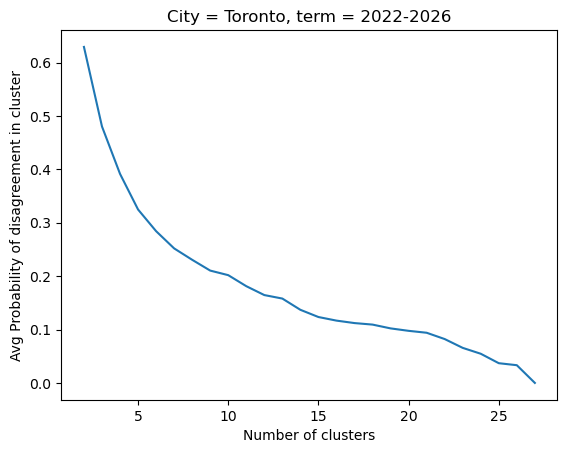

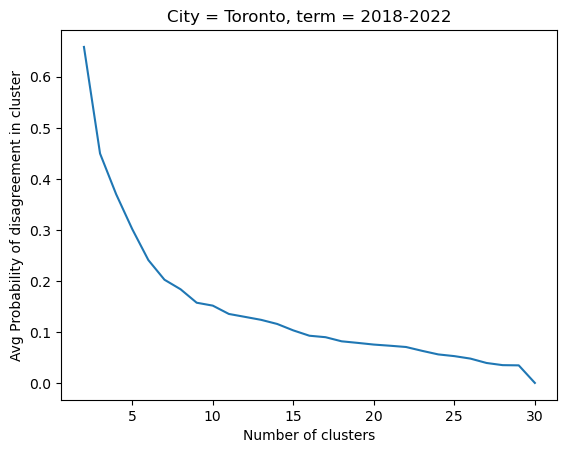

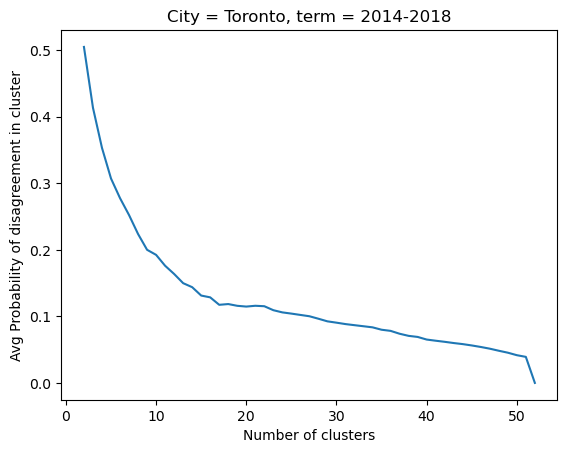

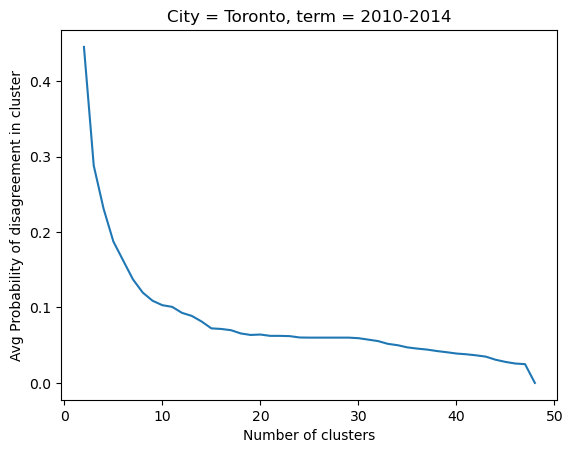

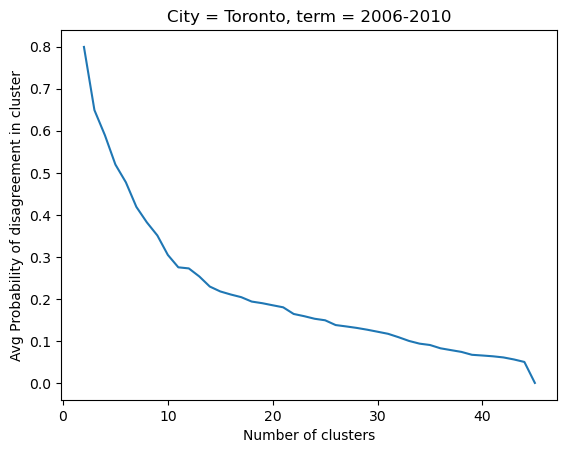

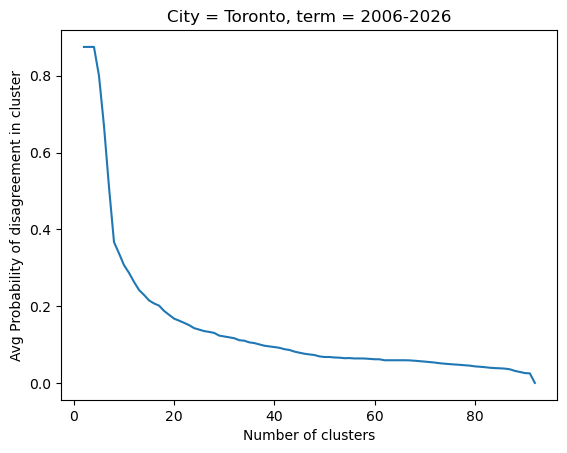

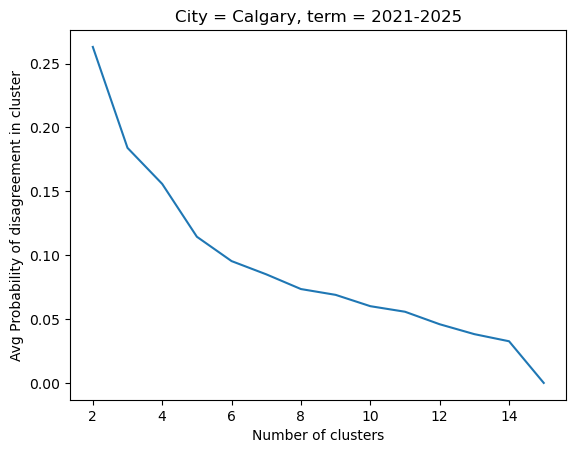

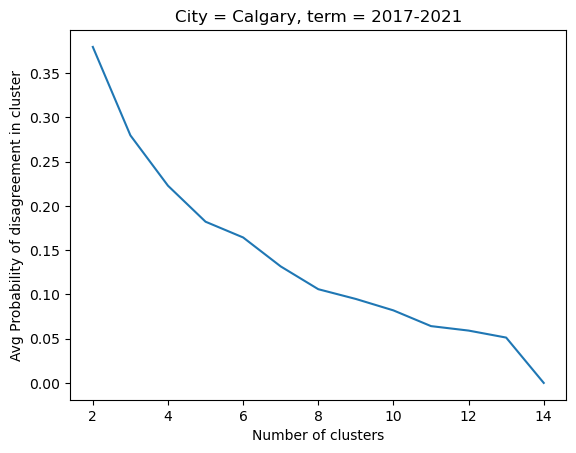

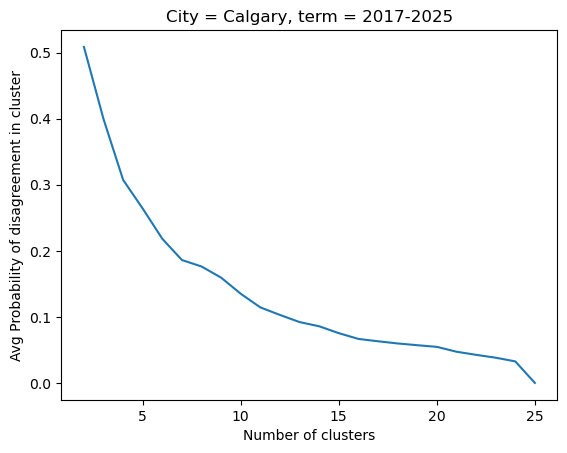

In [130]:
for city_id, term_list in terms.items():
    for term in term_list:
        plt.figure()
        plt.title(f'City = {city_dict[city_id]}, term = {term}')
        plt.xlabel('Number of clusters')
        plt.ylabel('Avg Probability of disagreement in cluster')
        plt.plot(nClus_to_obj_func[city_id][term].keys(),nClus_to_obj_func[city_id][term].values())


In [131]:

# get number of clusters when obj func > 0.1
n_clus = {}

for city_id, term_dict in nClus_to_obj_func.items():
    n_clus[city_id] = {}
    for term, nclus_obj_func_dict in term_dict.items():
        print(f'City = {city_dict[city_id]}, term = {term}')
        for n, obj_func in nclus_obj_func_dict.items():
            if obj_func > 0.175:
                n_clus[city_id][term] = n
                break
        print(f'  n_clus = {n_clus[city_id][term]}')

City = Toronto, term = 2022-2026
  n_clus = 11
City = Toronto, term = 2018-2022
  n_clus = 8
City = Toronto, term = 2014-2018
  n_clus = 11
City = Toronto, term = 2010-2014
  n_clus = 5
City = Toronto, term = 2006-2010
  n_clus = 21
City = Toronto, term = 2006-2026
  n_clus = 19
City = Calgary, term = 2021-2025
  n_clus = 3
City = Calgary, term = 2017-2021
  n_clus = 5
City = Calgary, term = 2017-2025
  n_clus = 8


In [132]:
def getNamesInClusters(clus_ids, clusters, id_to_name):
    cur_clusters = [clusters[clus_id][0] for clus_id in clus_ids]
    return [[id_to_name[x] for x in clus] for clus in cur_clusters]

In [133]:
def printNamesFromIds(list_of_ids, id_to_name):
    name_list = [id_to_name[x] for x in list_of_ids]
    string = ''
    for name in name_list:
        if name is name_list[-1]:
            string += name
        else:
            string += name + ', '
            
    print(string)
    return

In [134]:
for city_id, term_list in terms.items():
    for term in term_list:
        print(f'City = {city_dict[city_id]}, term = {term}')
        final_clusters = getNamesInClusters(clus_timeline[city_id][term][n_clus[city_id][term]],clusters_id[city_id][term],id_to_name[city_id][term])
        for i, clus in enumerate(final_clusters):
            string = ''
            for name in clus:
                if name is clus[-1]:
                    string += name
                else:
                    string += name + ', '

            print(i+1,string)

        print(' ')

City = Toronto, term = 2022-2026
1 Anthony Perruzza
2 James Pasternak
3 Jaye Robinson
4 Lily Cheng
5 Mike Colle
6 Stephen Holyday
7 Amber Morley, Paula Fletcher
8 Dianne Saxe, Jamaal Myers, Olivia Chow, Chris Moise, Shelley Carroll
9 Josh Matlow, Gord Perks, Alejandra Bravo, Ausma Malik
10 Jon Burnside, Michael Thompson
11 Gary Crawford, Vincent Crisanti, Paul Ainslie, Nick Mantas, Frances Nunziata, Brad Bradford, Jennifer McKelvie, John Tory
 
City = Toronto, term = 2018-2022
1 Rose Milczyn
2 Paul Ainslie, Ana BailÃ£o, Brad Bradford, Cynthia Lai, Michael Thompson
3 Jim Karygiannis, Anthony Perruzza, Mike Colle
4 Denzil Minnan-Wong, Jaye Robinson
5 Josh Matlow, Gord Perks, Kristyn Wong-Tam, Paula Fletcher, Joe Cressy, Mike Layton
6 Gary Crawford, James Pasternak, Frances Nunziata, Jennifer McKelvie, John Tory, Mark Grimes, Nick Mantas
7 Michael Ford, Stephen Holyday
8 Joe Mihevc, Robin Buxton Potts, John Filion, Shelley Carroll
 
City = Toronto, term = 2014-2018
1 Giorgio Mammoliti
2 R

So there we have it! I like to see Fords and Holydays generally placed together, and Tory with McKelvie also matches expectations. I'm a lot less knowledgeable about Calgary politics, but my brother who is a lot more in-the-know there says "That's largely correct. I'd accept that sorting". High praise indeed!

Let's store all the network graphs in the following style: `{city_id: {term_id: df/graph}}` so we can easily keep track of all our networks and the dataframes used to build them.

In [135]:
def getClusIdForName(name, cluster_list):
    for i, clus in enumerate(cluster_list):
        if name in clus:
            return i
    return -1

Voting similarity network for Toronto city council for the 2022-2026 term


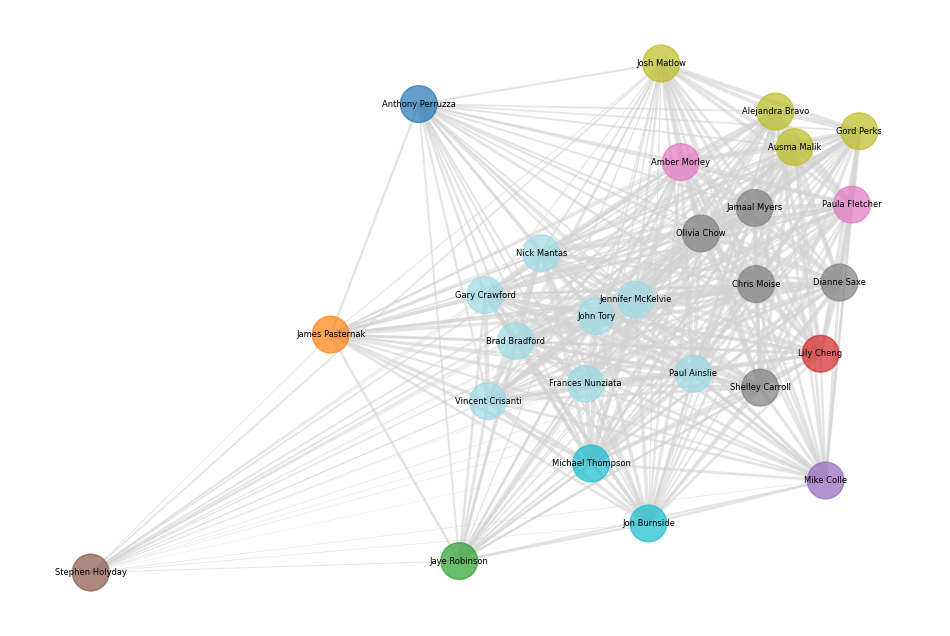

Voting similarity network for Toronto city council for the 2018-2022 term


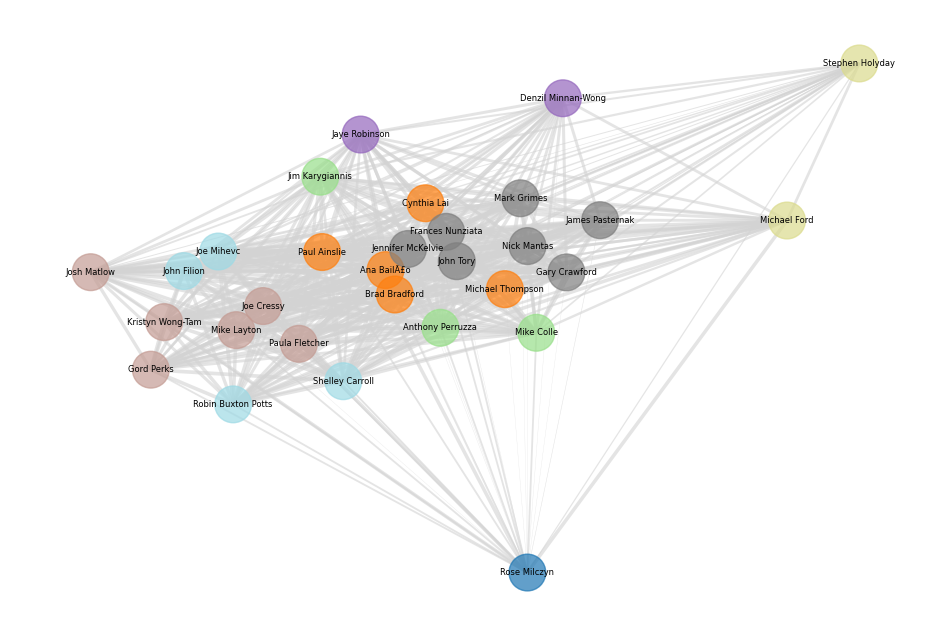

Voting similarity network for Toronto city council for the 2014-2018 term


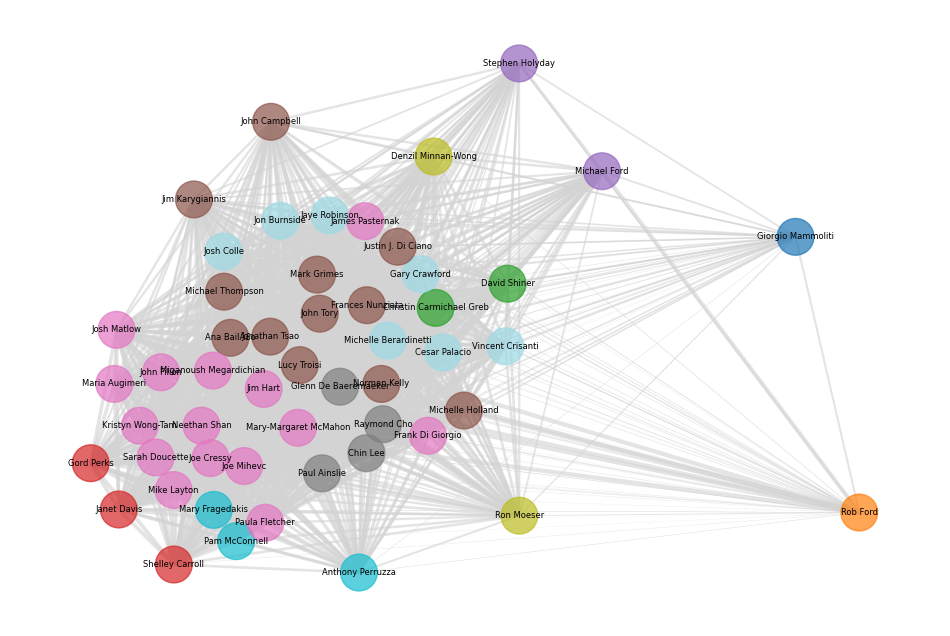

Voting similarity network for Toronto city council for the 2010-2014 term


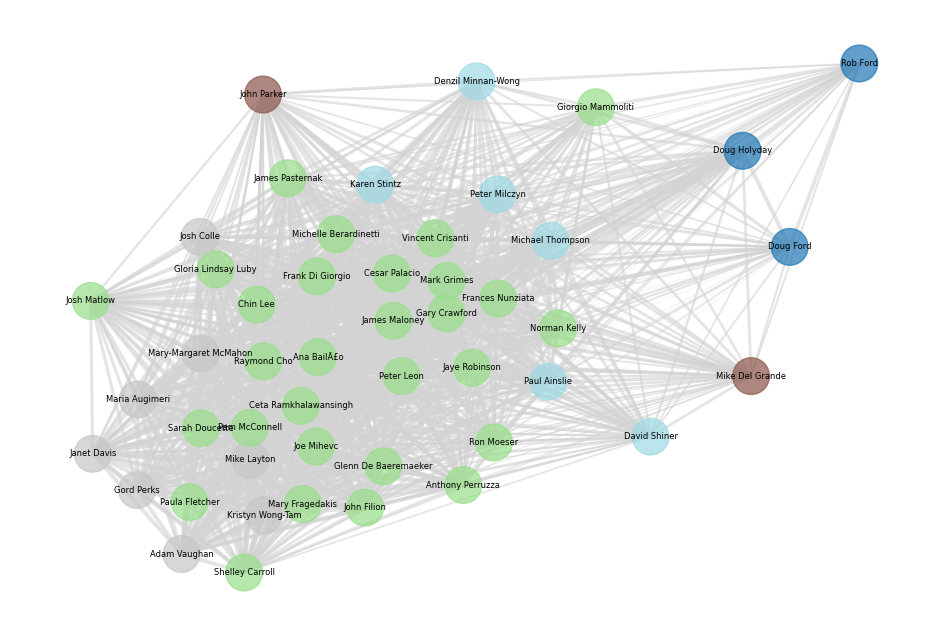

Voting similarity network for Toronto city council for the 2006-2010 term


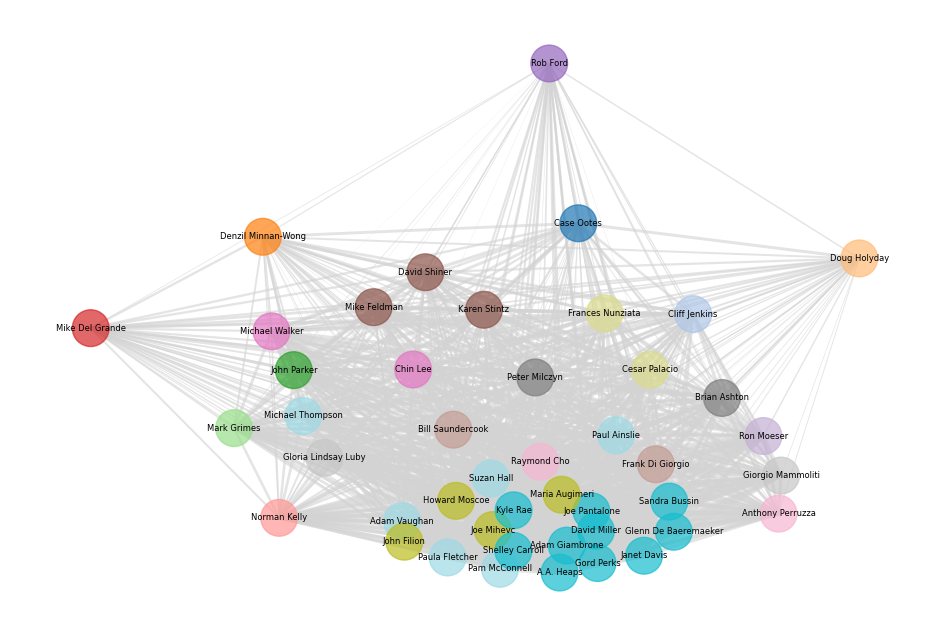

Voting similarity network for Toronto city council for the 2006-2026 term


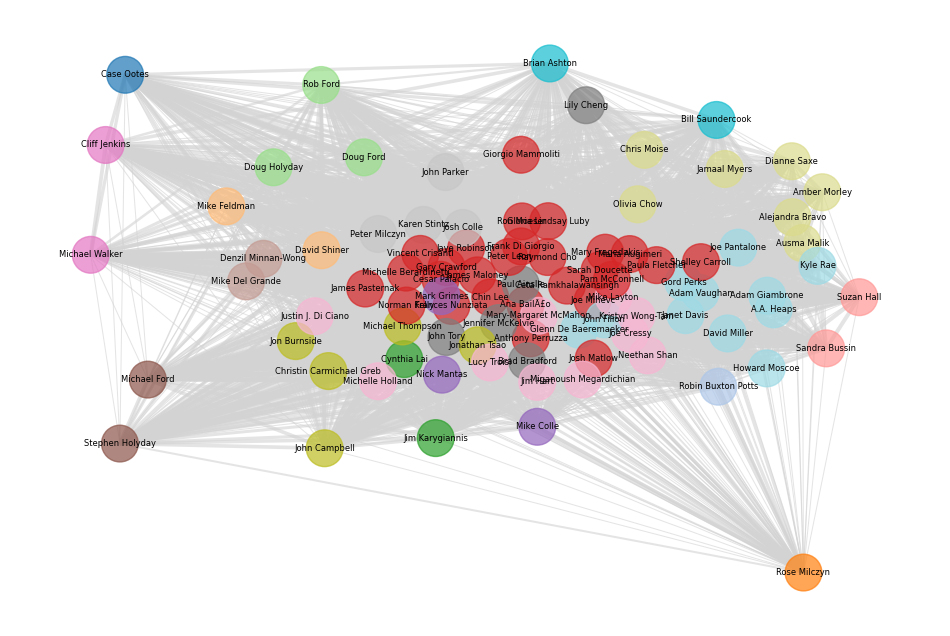

Voting similarity network for Calgary city council for the 2021-2025 term


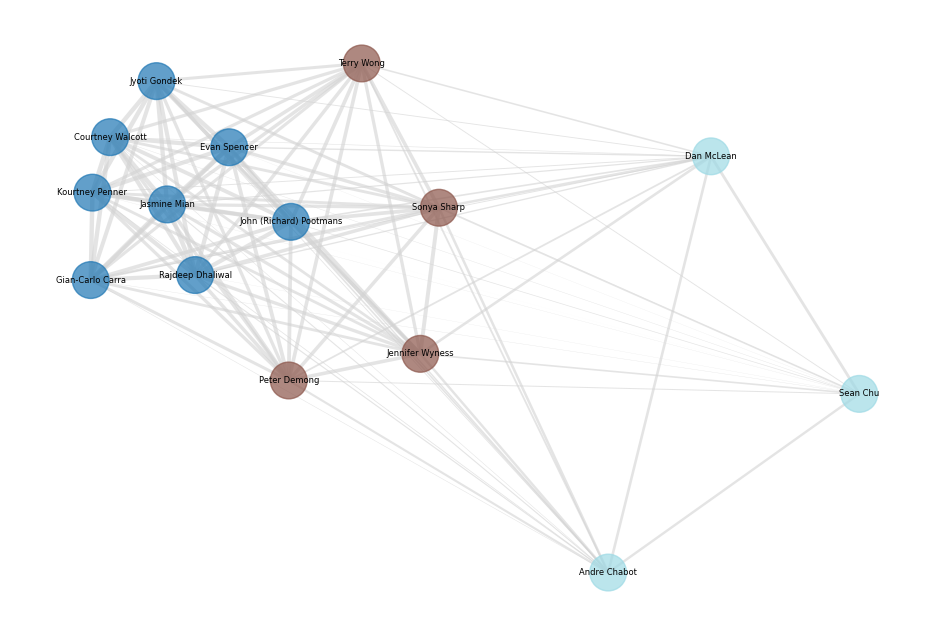

Voting similarity network for Calgary city council for the 2017-2021 term


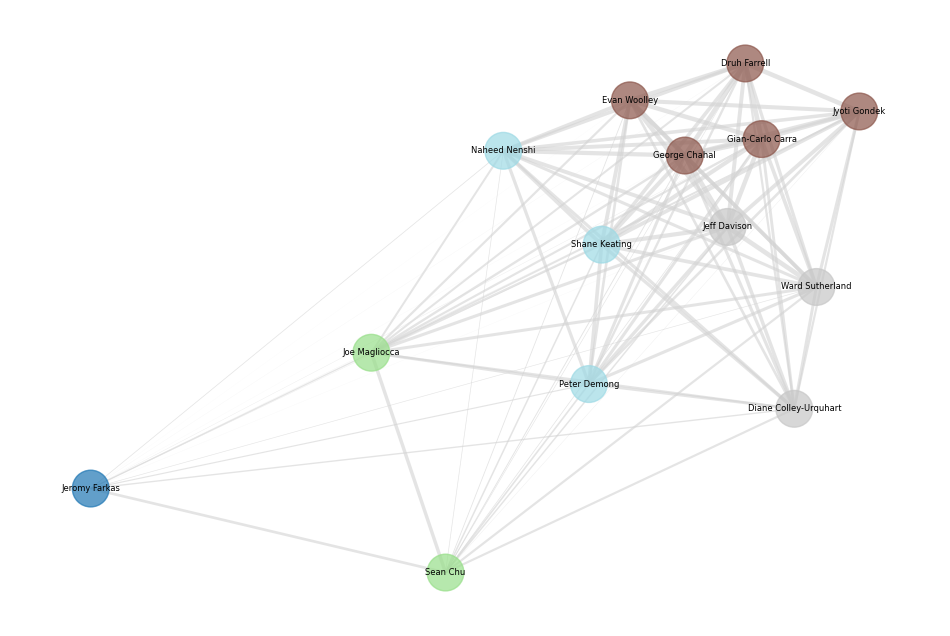

Voting similarity network for Calgary city council for the 2017-2025 term


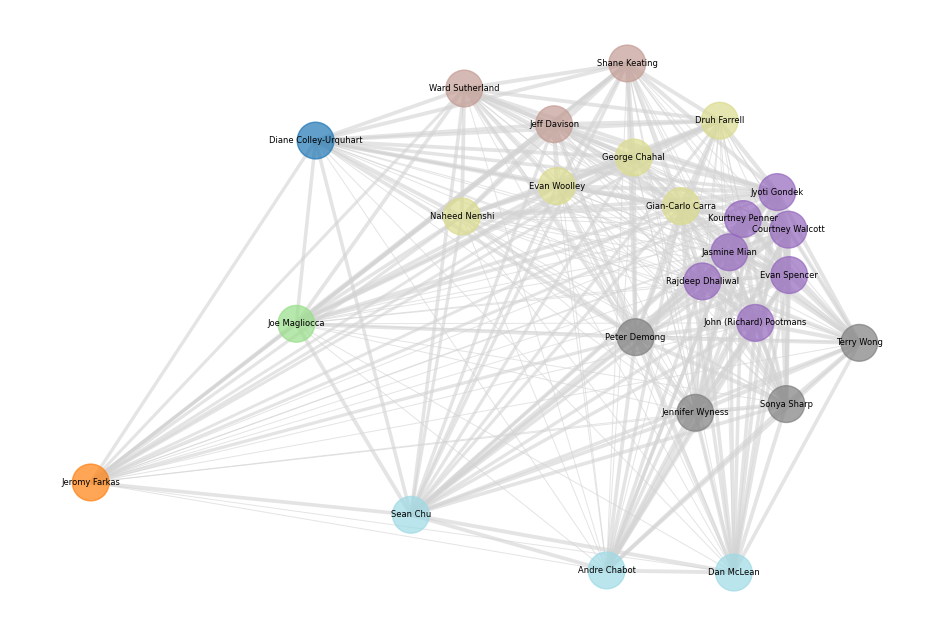

In [136]:
for city_id, term_df_dict in A_term_df.items():
    for term, df in term_df_dict.items():
        print(f'Voting similarity network for {city_dict[city_id]} city council for the {term} term')
        
        G=nx.from_pandas_adjacency(1-A_term_df[city_id][term])

        # Make network line thicknesses related to the strength of the connection between the two nodes (councillors)
        widths = nx.get_edge_attributes(G, 'weight')
        widths_mean = np.mean(list(widths.values()))
        widths_std = np.std(list(widths.values()))
        widths.update((x, -(y-widths_mean)/widths_std+2) for x, y in widths.items())

        nodelist = G.nodes()
        node_names = [id_to_name[city_id][term][i] for i in list(nodelist)]
        
        #if city_id == 0:
        #    n_clus = 6
        #elif city_id ==1:
        #    n_clus = 4
        final_clusters = getNamesInClusters(clus_timeline[city_id][term][n_clus[city_id][term]],clusters_id[city_id][term],id_to_name[city_id][term])
        nodelist_clus = []
        for i, node in enumerate(node_names):
            nodelist_clus.append(getClusIdForName(node, final_clusters))
        
        plt.figure(figsize=(12,8))

        # There are two reasonable options for the node locations: 
        # the spring_layout seems to have difficulty with prioritizing keeping nodes from overlapping too much
        #pos = nx.spring_layout(G,weight='weight')
        pos = nx.kamada_kawai_layout(G,weight='weight')
        nx.draw_networkx_nodes(G,pos,
                               nodelist=nodelist,
                               node_size=700,#node_size=1500,
                               node_color=nodelist_clus,
                               cmap='tab20',
                               alpha=0.7)
        nx.draw_networkx_edges(G,pos,
                               edgelist = widths.keys(),
                               width=list(widths.values()),
                               edge_color='lightgrey',
                               alpha=0.6)
        nx.draw_networkx_labels(G, pos=pos,
                                labels=dict(zip(nodelist,node_names)),
                                font_color='black',
                                font_size = 6)#font_size = 8)
        plt.box(False)
        plt.show()

In [139]:
# Can we do Hartigan-Wong to clean up a bit?

new_clusters_id = {}
clus_elems_final = {}
moved_elem_list = {}

for city_id, term_df_dict in pivot_term_df.items():
    #if city_id != 0:
    #    continue
        
    new_clusters_id[city_id] = {}
    clus_elems_final[city_id] = {}
    moved_elem_list[city_id] = {}
    for term, df in term_df_dict.items():
        #if term != '2022-2026':
        #    continue
        print(f'City = {city_dict[city_id]}, term = {term}')
        
        new_clusters_id[city_id][term] = clusters_id[city_id][term].copy()
        
        n_clus_init = n_clus[city_id][term]
        clus_init = clus_timeline[city_id][term][n_clus_init].tolist()
        print(clus_init)
        clus_elems_init = dict((k, clusters_id[city_id][term][k]) for k in clus_init)
        
        # clus_df keeps track of which clusters have been exhaustively checked against each other
        clus_df = pd.DataFrame(data = False, columns=clus_init,index=clus_init,dtype=bool)
        
        # diagonal should be True, clusters have been checked against themselves
        for clus1 in clus_df.columns:
            clus_df.at[clus1,clus1] = True     
            
        move_elem = True
        moved_elem_list[city_id][term] = []
        while move_elem:

            move_elem, new_clusters_id[city_id][term], clus_df, elem = findFirstMove(new_clusters_id[city_id][term], clus_df, id_to_name[city_id][term], df)
            moved_elem_list[city_id][term].append(elem)
            print(move_elem, elem)
            #move_elem = False
        

        clus_elems_final[city_id][term] = dict((k, new_clusters_id[city_id][term][k]) for k in clus_df.columns)
#print(clus_elems_init)
#print(clus_elems_final)
#clusters_id[0]['2022-2026']

City = Toronto, term = 2022-2026
[2, 11, 12, 17, 19, 25, 33, 39, 40, 41, 42]
True 16
True 9
False -1
City = Toronto, term = 2018-2022
[27, 45, 46, 47, 48, 49, 50, 51]
True 3
True 14
True 10
True 14
True 28
True 20
True 24
True 1
True 0
True 0
True 3
True 8
True 6
True 5
True 20
True 18
False -1
City = Toronto, term = 2014-2018
[10, 46, 71, 75, 79, 84, 88, 89, 90, 91, 92]
True 12
True 29
True 11
True 1
True 35
True 25
True 45
True 20
True 11
True 6
True 22
True 9
True 7
True 15
True 0
True 23
True 12
True 45
True 51
True 14
True 43
True 1
True 51
True 33
True 36
True 31
True 47
True 11
True 3
True 9
True 23
True 45
False -1
City = Toronto, term = 2010-2014
[82, 85, 86, 89, 90]
True 9
True 28
True 38
True 19
False -1
City = Toronto, term = 2006-2010
[6, 9, 12, 13, 25, 29, 32, 34, 40, 41, 56, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68]
True 20
True 2
True 22
True 35
False -1
City = Toronto, term = 2006-2026
[11, 83, 85, 116, 136, 142, 146, 148, 151, 152, 153, 156, 157, 158, 160, 161, 162, 163

In [138]:
def findFirstMove(in_clusters_id, in_clus_df, id_to_name, pivot_df):
    #print('in findFirstMove')
    # return params
    clusters_id = in_clusters_id.copy()
    clus_df = in_clus_df.copy()
    
    for give_id in clus_df.columns:
        give_prob_old = clusters_id[give_id][1]
        give_list = clusters_id[give_id][0]
        n_large_old = 2 if len(give_list) > 1 else 1
        n_large_new = 2 if len(give_list) > 2 else 1
        #print(f'give = {clusters_id[give_id]}')

        if len(give_list) > 1:
            #print(f'give cluster is non-singleton')
            for take_id in clus_df.index:
                if clus_df[take_id][give_id] == True:#clus_df[give_id][take_id] == True:
                    continue

                take_prob_old = clusters_id[take_id][1]
                take_list = clusters_id[take_id][0]
                #print(f'take = {clusters_id[take_id]}')
                old_obj_func = (give_prob_old + take_prob_old)/n_large_old

                for elem in give_list:
                    give_list_new = give_list.copy()
                    give_list_new.remove(elem)
                    take_list_new = take_list + [elem]
                    give_prob_new = 1 - getProbUnanimous([id_to_name[x] for x in give_list_new],pivot_df)
                    take_prob_new = 1 - getProbUnanimous([id_to_name[x] for x in take_list_new],pivot_df)
                    #print(f'give_new = {(give_list_new, give_prob_new)}')
                    #print(f'take_new = {(take_list_new, take_prob_new)}')
                    
                    #print(f'is {(give_prob_new + take_prob_new)/n_large_new} < {old_obj_func} ?')
                    
                    if (give_prob_new + take_prob_new)/n_large_new < old_obj_func:
                        #print('yes!')
                        # do the move
                        take_id_new = max(clusters_id.keys()) + 1
                        clusters_id.update({take_id_new:(take_list_new, take_prob_new)})
                        give_id_new = max(clusters_id.keys()) + 1
                        clusters_id.update({give_id_new:(give_list_new, give_prob_new)})
                        
                        clus_df = clus_df.drop(take_id, axis=0).drop(take_id, axis=1).drop(give_id, axis=0).drop(give_id, axis=1)
                        
                        new_row = [False] * len(clus_df.columns)
                        clus_df.loc[take_id_new] = new_row
                        new_row.append(True)
                        clus_df[take_id_new] = new_row
                        
                        new_row = [False] * len(clus_df.columns)
                        clus_df.loc[give_id_new] = new_row
                        new_row.append(True)
                        clus_df[give_id_new] = new_row
                        
                        #display(clus_df)
                        return True, clusters_id, clus_df, elem
                #print(f'updating clus_df at [give_id, take_id]=[{give_id},{take_id}]')
                clus_df.at[give_id, take_id] = True
        else: #if len(clusters_id[give_id][0]) == 1:
            #print(f'give cluster is singleton')
            for take_id in clus_df.index:
                if clus_df[take_id][give_id] == True:
                    continue

                take_prob_old = clusters_id[take_id][1]
                take_list = clusters_id[take_id][0]

                take_list_new = take_list + give_list
                take_prob_new = 1 - getProbUnanimous([id_to_name[x] for x in take_list_new],pivot_df)
                if take_prob_new < 0.15:
                    # do the move
                    take_id_new = max(clusters_id.keys()) + 1
                    clusters_id.update({take_id_new:(take_list_new, take_prob_new)})

                    clus_df = clus_df.drop(take_id, axis=0).drop(take_id, axis=1).drop(give_id, axis=0).drop(give_id, axis=1)

                    new_row = [False] * len(clus_df.columns)
                    clus_df.loc[take_id_new] = new_row
                    new_row.append(True)
                    clus_df[take_id_new] = new_row
                    display(clus_df)
                    return True, clusters_id, clus_df, give_list[0]
                
                clus_df.at[give_id, take_id] = True
    #display(clus_df)
    return False, in_clusters_id, clus_df, -1
                        

In [124]:
print(id_to_name[0]['2022-2026'][16])
print(id_to_name[0]['2022-2026'][9])


Josh Matlow
Gord Perks


Voting similarity network for Toronto city council for the 2022-2026 term
The following councillors moved thanks to Hartigan-Wong:
Josh Matlow, Gord Perks


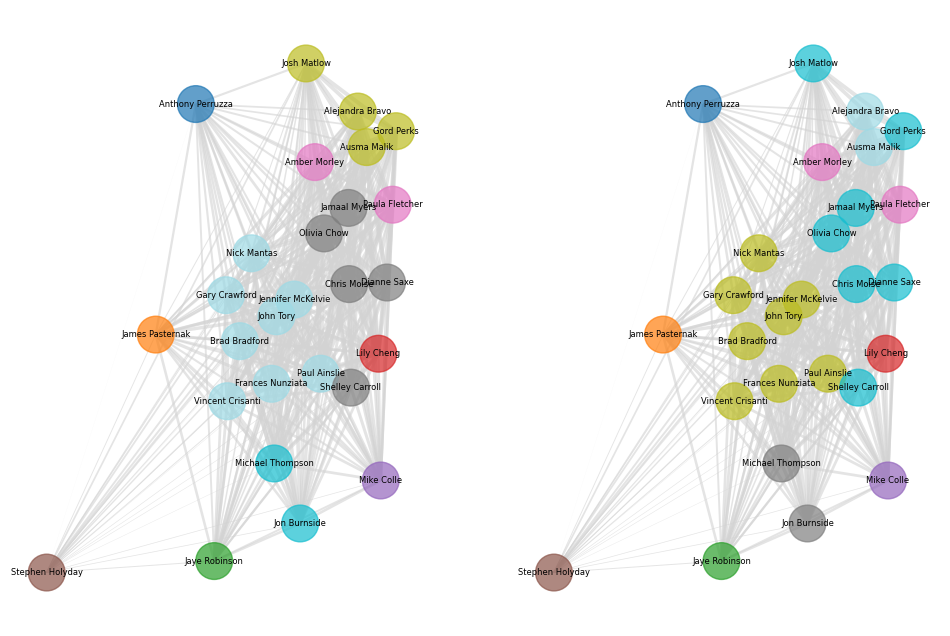

Voting similarity network for Toronto city council for the 2018-2022 term
The following councillors moved thanks to Hartigan-Wong:
Cynthia Lai, John Filion, Jennifer McKelvie, John Filion, Shelley Carroll, Michael Thompson, Paul Ainslie, Anthony Perruzza, Ana BailÃ£o, Ana BailÃ£o, Cynthia Lai, James Pasternak, Gary Crawford, Frances Nunziata, Michael Thompson, Mark Grimes


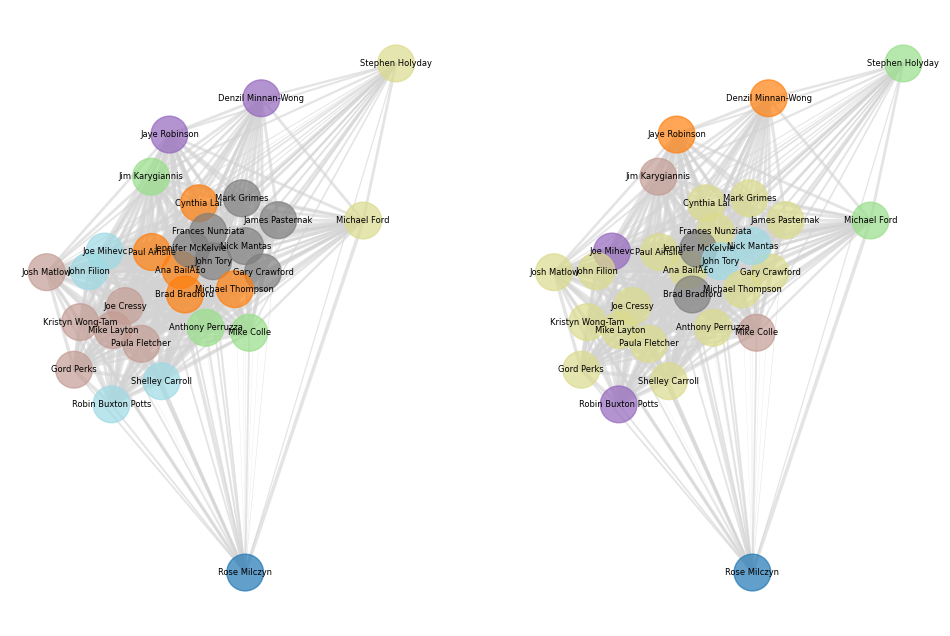

Voting similarity network for Toronto city council for the 2014-2018 term
The following councillors moved thanks to Hartigan-Wong:
Gord Perks, Lucy Troisi, Glenn De Baeremaeker, Anthony Perruzza, Michael Thompson, Josh Colle, Raymond ChoJohn Campbell, Glenn De Baeremaeker, Denzil Minnan-Wong, John Tory, Gary Crawford, Frances Nunziata, Jaye Robinson, Ana BailÃ£o, Jon Burnside, Gord Perks, Raymond ChoVincent Crisanti, Janet Davis, Paul Ainslie, Anthony Perruzza, Vincent Crisanti, Mary-Margaret McMahon, Michelle Berardinetti, Mark Grimes, Ron Moeser, Glenn De Baeremaeker, Chin Lee, Gary Crawford, Jon Burnside, Raymond Cho


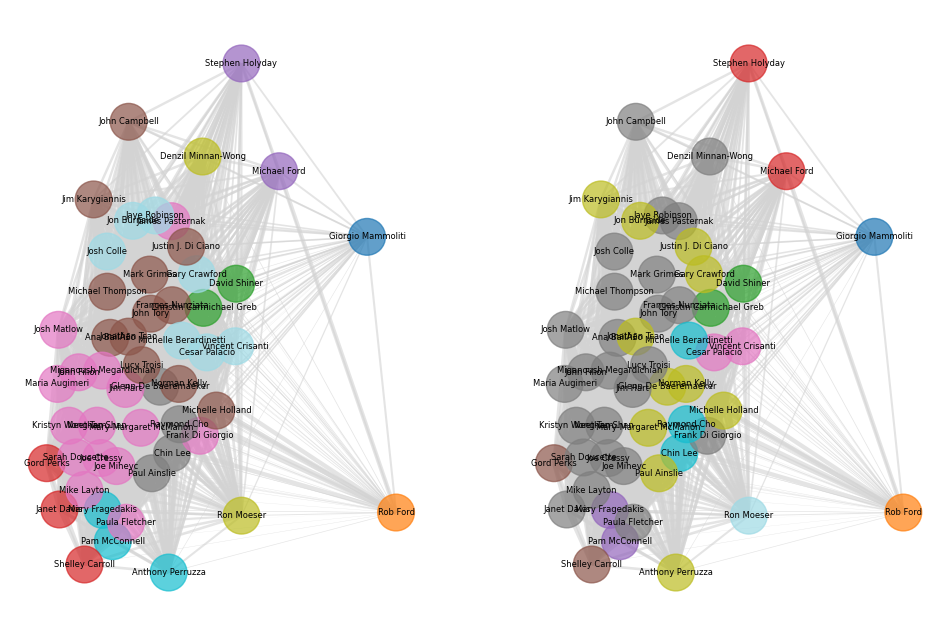

Voting similarity network for Toronto city council for the 2010-2014 term
The following councillors moved thanks to Hartigan-Wong:
Doug Holyday, Maria Augimeri, Paul Ainslie, Janet Davis


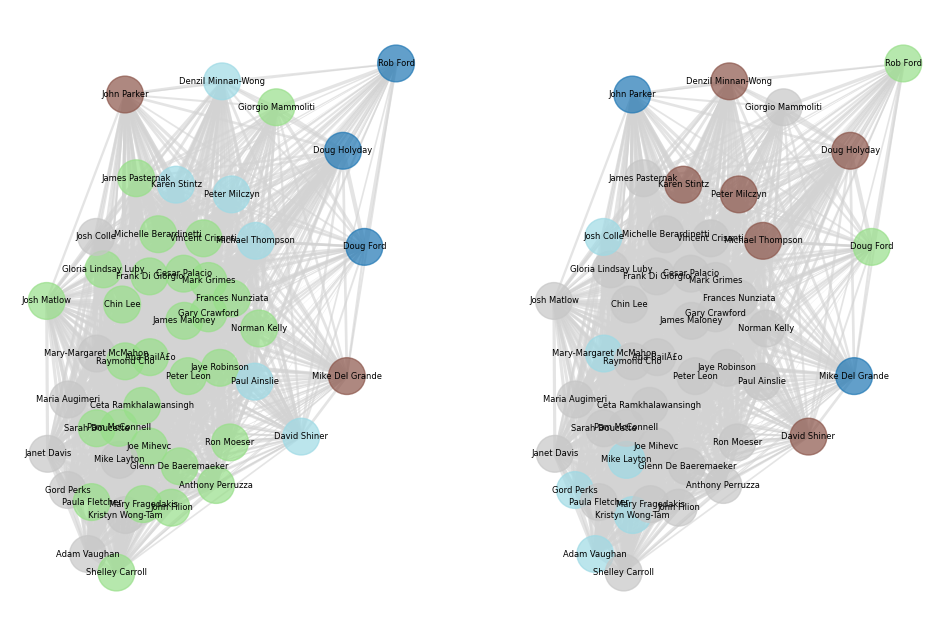

Voting similarity network for Toronto city council for the 2006-2010 term
The following councillors moved thanks to Hartigan-Wong:
Howard Moscoe, Adam Vaughan, Joe Mihevc, Pam McConnell


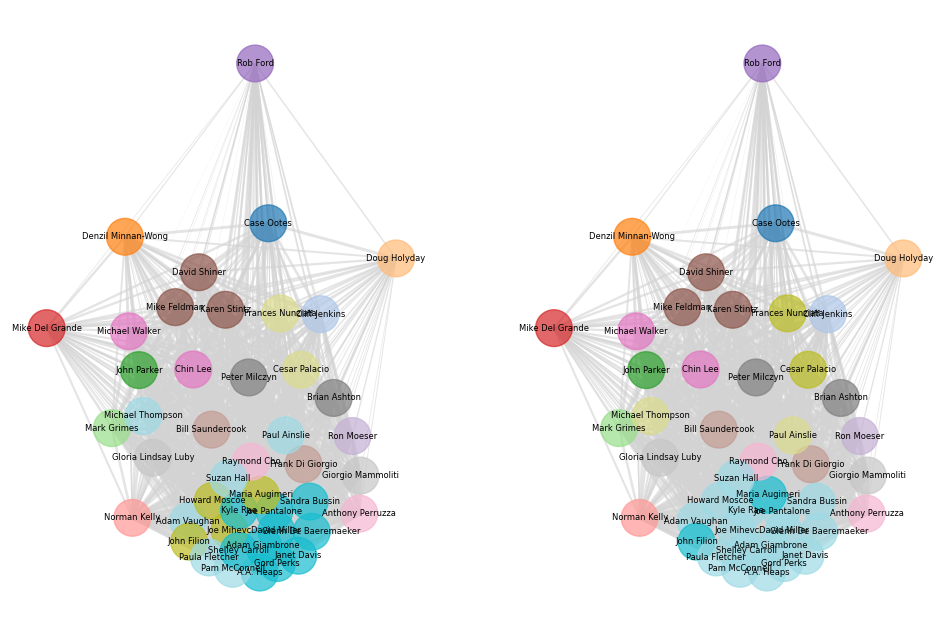

Voting similarity network for Toronto city council for the 2006-2026 term
The following councillors moved thanks to Hartigan-Wong:
Mary Fragedakis, Mike Colle, Paul Ainslie, Josh Colle, John Filion, Mike Colle, Paul Ainslie, Michael Thompson, Karen Stintz, Gord Perks, Ana BailÃ£oKaren Stintz, Rob Ford, Glenn De Baeremaeker, Joe Mihevc, Josh Colle, Denzil Minnan-Wong, Janet Davis, Glenn De Baeremaeker, Glenn De Baeremaeker, Ana BailÃ£o


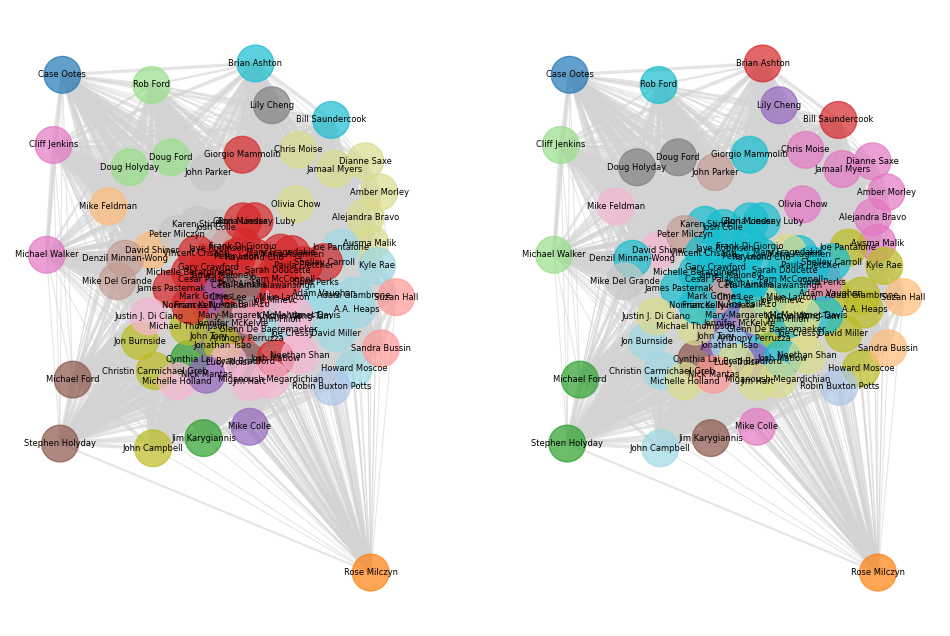

Voting similarity network for Calgary city council for the 2021-2025 term
The following councillors moved thanks to Hartigan-Wong:
John (Richard) Pootmans


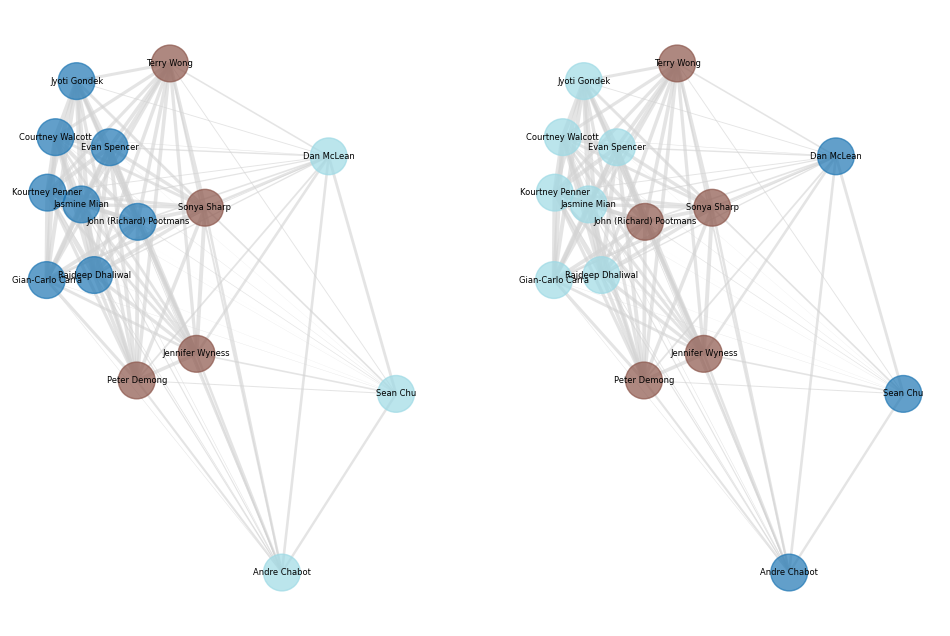

Voting similarity network for Calgary city council for the 2017-2021 term
The following councillors moved thanks to Hartigan-Wong:
Diane Colley-Urquhart, Naheed Nenshi, Shane Keating


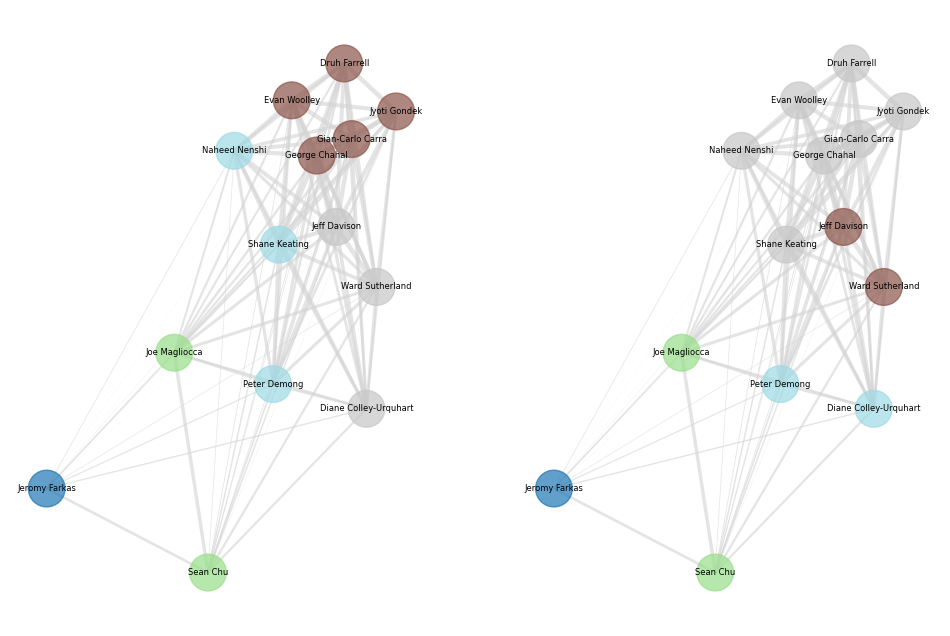

Voting similarity network for Calgary city council for the 2017-2025 term
The following councillors moved thanks to Hartigan-Wong:
John (Richard) Pootmans, Shane Keating


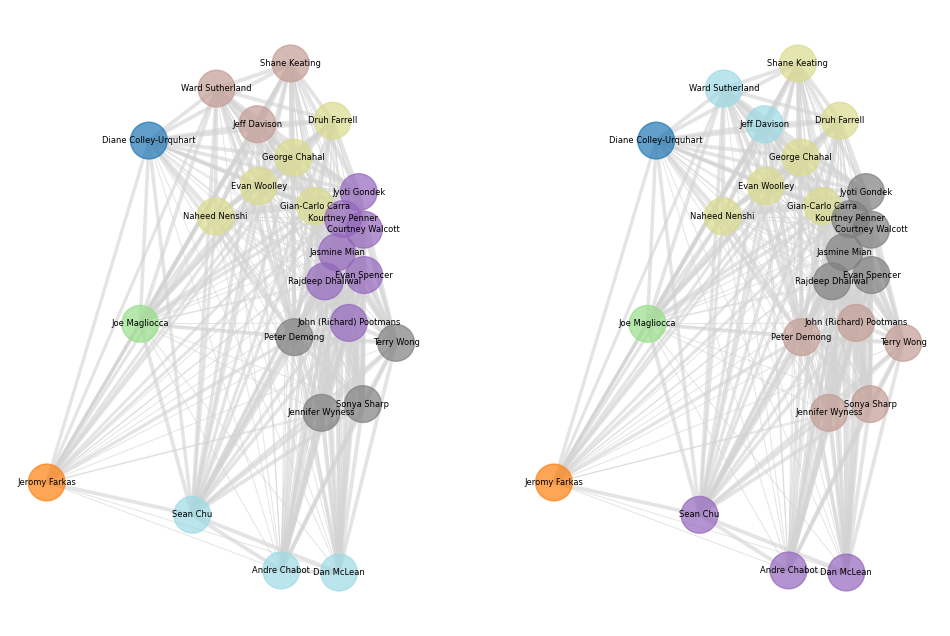

In [143]:
for city_id, term_df_dict in A_term_df.items():
    #if city_id != 0:
    #    continue
    for term, df in term_df_dict.items():
        #if term != '2022-2026':
        #    continue
        print(f'Voting similarity network for {city_dict[city_id]} city council for the {term} term')
        print('The following councillors moved thanks to Hartigan-Wong:')
        if -1 in moved_elem_list[city_id][term]:
            moved_elem_list[city_id][term].remove(-1)
        printNamesFromIds(moved_elem_list[city_id][term], id_to_name[city_id][term])
        
        G=nx.from_pandas_adjacency(1-A_term_df[city_id][term])

        # Make network line thicknesses related to the strength of the connection between the two nodes (councillors)
        widths = nx.get_edge_attributes(G, 'weight')
        widths_mean = np.mean(list(widths.values()))
        widths_std = np.std(list(widths.values()))
        widths.update((x, -(y-widths_mean)/widths_std+2) for x, y in widths.items())

        nodelist = G.nodes()
        node_names = [id_to_name[city_id][term][i] for i in list(nodelist)]
        
        #if city_id == 0:
        #    n_clus = 6
        #elif city_id ==1:
        #    n_clus = 4
        final_clusters = getNamesInClusters(clus_timeline[city_id][term][n_clus[city_id][term]],clusters_id[city_id][term],id_to_name[city_id][term])
        nodelist_clus = []
        for i, node in enumerate(node_names):
            nodelist_clus.append(getClusIdForName(node, final_clusters))
        
        plt.figure(figsize=(12,8))
        plt.subplot(121)




        #plt.figure(figsize=(12,8))

        # There are two reasonable options for the node locations: 
        # the spring_layout seems to have difficulty with prioritizing keeping nodes from overlapping too much
        #pos = nx.spring_layout(G,weight='weight')
        pos = nx.kamada_kawai_layout(G,weight='weight')
        nx.draw_networkx_nodes(G,pos,
                               nodelist=nodelist,
                               node_size=700,#node_size=1500,
                               node_color=nodelist_clus,
                               cmap='tab20',
                               alpha=0.7)
        nx.draw_networkx_edges(G,pos,
                               edgelist = widths.keys(),
                               width=list(widths.values()),
                               edge_color='lightgrey',
                               alpha=0.6)
        nx.draw_networkx_labels(G, pos=pos,
                                labels=dict(zip(nodelist,node_names)),
                                font_color='black',
                                font_size = 6)#font_size = 8)
        plt.box(False)
        #plt.show()
        
        
        # now again for new clusters:
        final_clusters = getNamesInClusters(clus_elems_final[city_id][term],new_clusters_id[city_id][term],id_to_name[city_id][term])
        nodelist_clus = []
        for i, node in enumerate(node_names):
            nodelist_clus.append(getClusIdForName(node, final_clusters))
        
        #plt.figure(figsize=(12,8))
        plt.subplot(122)

        # There are two reasonable options for the node locations: 
        # the spring_layout seems to have difficulty with prioritizing keeping nodes from overlapping too much
        #pos = nx.spring_layout(G,weight='weight')
        pos = nx.kamada_kawai_layout(G,weight='weight')
        nx.draw_networkx_nodes(G,pos,
                               nodelist=nodelist,
                               node_size=700,#node_size=1500,
                               node_color=nodelist_clus,
                               cmap='tab20',
                               alpha=0.7)
        nx.draw_networkx_edges(G,pos,
                               edgelist = widths.keys(),
                               width=list(widths.values()),
                               edge_color='lightgrey',
                               alpha=0.6)
        nx.draw_networkx_labels(G, pos=pos,
                                labels=dict(zip(nodelist,node_names)),
                                font_color='black',
                                font_size = 6)#font_size = 8)
        plt.box(False)
        plt.show()

---
---
---

In [23]:
# Make agreement matrix symmetric, and make NA's into zeroes, and make diagonal into 1
for city_id, term_df_dict in A_term_df.items():
    for term, df in term_df_dict.items():
        cols = df.columns
        rem_cols = cols.copy()
        for col1 in cols:
            df.at[col1,col1] = 1
            rem_cols.drop(col1)
            for col2 in rem_cols:
                df.at[col2,col1] = df.at[col1,col2]
        df.fillna(0, inplace=True)

In [27]:
# Create an agreement matrix
A_term_df = {}
for city_id, term_list in terms.items():
    A_term_df[city_id] = {}
    for term in term_list:
        a_df = n_term_df[city_id][term]-d_term_df[city_id][term]
        A_term_df[city_id][term] = (a_df+1) / (n_term_df[city_id][term]+2)

NameError: name 'n_term_df' is not defined

---

---

---

Since $D_{ij}$ and $w_{ij}$ can be performed element-wise, they are much simpler and easier to compute!

In [44]:
D_term_df = {}
w_term_df = {}

for city_id, term_list in terms.items():
    D_term_df[city_id] = {}
    w_term_df[city_id] = {}
    for term in term_list:
        D_term_df[city_id][term] = (d_term_df[city_id][term]+1)/(n_term_df[city_id][term]+2)
        w_term_df[city_id][term] = 1/((d_term_df[city_id][term]+1)*(n_term_df[city_id][term]-d_term_df[city_id][term]+1)/((n_term_df[city_id][term]+2)**2*(n_term_df[city_id][term]+3)))


Despite these matrices being symmetric, so we can fill in the bottom-left values with the top-right values, these matrices are still pretty sparse! This is because plenty of councillors never served with other councillors on this list, and so we can't directly state how similar or dissimilar they are. 

I did my fair share of googling clustering algorithms for sparse boolean non-euclidean data with weights, but found nothing satisfying. Imputting our missing values with something meaningful would be helpful, but that's not intuitive.

Still, this is supposed to be a *fun* project, and to me, inventing a clustering algorithm from scratch actually does seem ***fun***!

To make the clustering easier, it would be really nice if we could fill in the missing entries in our dissimilarity matrix. If we know $D_{AB}$ and $D_{BC}$ but not $D_{AC}$, is there anything we can say about it anyway? And can we bias our results so that our clustering will prefer to group councillors who coexisted simultaneously over their hypothetical time-travelling colleagues?

One idea that comes to mind comes from looking at the probabilities of agreement, or $A_{AB} = 1-D_{AB}$. Specifically the probability of A and B agreeing would be connected to the probability of A agreeing with i, and i agreeing with B. In math:

$$A_{AB,i}=A_{Ai}A_{iB}$$
$$D_{AB,i}=1-(1-D_{Ai})(1-D_{iB})$$

With the weights being the inverse variances, we should probably find $w_{AC}$ too while we're at it. Using the *actually not very great* assumption that these are gaussian variances, we can propagate our uncertainty as follows:

$$\sigma_{AB,i}^2 = D_{AB,i}^2 \left[\frac{\sigma_{Ai}^2}{(1-D_{Ai})^2}+\frac{\sigma_{iB}^2}{(1-D_{iB})^2}\right]$$

Of course since these are probabilities, $A,D\in[0,1]$, which means that the following relations are true:

$$A_{AB,i} < A_{Ai}, A_{iB}$$
$$D_{AB,i} > D_{Ai}, D_{iB}$$

But that's actually a good thing! If $D_{AB,i}$ is something to minimize in a cluster, then we want councillors to group with their co-existing colleagues first!

One final wrinkle arrives in the very likely event that councillors A and B never vote together, but there are many i,j,k,... councillors that vote with both A and B. How do we handle this? Since we already know how to calculate every path for $D_{AB,i}$ or $D_{AB,j}$, etc. along with every associated uncertainty, and we know these values are all bigger than their intermediate steps, we can  just find the mean of all these paths, weighted by their individual inverse variances! When taking the variance for this average, we have to remember to grab the weighted variance of the paths, not the weighted variance of the mean.

In other words, with $w_{AB,i}=\frac{1}{\sigma_{AB,i}^2}$ :

$$D_{AB} = \frac{\sum_{i}w_{AB,i}D_{AB,i}}{\sum_{i}w_{AB,i}}$$

$$\sigma_{AB}^2 = \frac{\sum_{i}w_{AB,i}(D_{AB,i}-D_{AB})^2}{\sum_{i}w_{AB,i}}$$

While there's no single correct answer for an imputation like this and there may be simpler options or more rigourous options, this choice seems to balance both in my mind and also winds up giving good results!

In [74]:
# Write out some functions that we'll use a lot of
def weightedVariance(input_vals):
    w_sum = w_sum2 = mean = S = 0

    for x, w in input_vals:
        w_sum = w_sum + w
        w_sum2 = w_sum2 + w**2
        mean_old = mean
        mean = mean_old + (w / w_sum) * (x - mean_old)
        S = S + w * (x - mean_old) * (x - mean)

    population_variance = S / w_sum
    # Bessel's correction for weighted samples
    # Frequency weights
    sample_frequency_variance = S / (w_sum - 1)
    return sample_frequency_variance
    
 #   mean = weightedMean(input_vals)
 #   num = 0
 #   denom = 0
 #   for v,w in input_vals:
 #       num += w*((v-mean)**2)
 #       denom += w**2
 #   return num/denom
        
def weightedMean(input_vals):
    num = 0
    denom = 0

    for v,w in input_vals:
        num += v*w
        denom += w
        
    return num/denom

This next function is probably the biggest user of processing time in this whole project. For lists of councillors any bigger, this would be the first target to be migrated to C or to be rewritten in some other fashion. 

The idea is to find all the missing values in the table, then use the connections between the councillors to fill in as much as we can. It's possible there are councillors with no other councillors connecting them, but that's okay, once we've filled in our missings once, we are far more likely to have just imputed a value that will help us make a new connection!

It's also possible that there is some set of councillors who have never voted with another set of councillors, and that no connecting councillor exist. In that case, this will fail, but so too will our entire clustering process. This seems a very unlikely situation however, so it falls in the category of "problems that might not actually be problems".

In [66]:
def imputeMissings(clus_df, wclus_df, verbose = False):
    # this function alters clus_df and wclus_df!
    
    i=0
    while clus_df.isna().sum().sum() > 0:
        if verbose:
            print(f'in while loop, i={i}')
        i+=1
        
        # find array locations of all missing elements
        nans = np.where(clus_df != clus_df)
        if verbose:
            print(f'--There are {len(nans[0])} missing elements')
        
        j=0
        #iterate through missings and find where the two unconnected nodes have a node in common
        for nans_row, nans_col in zip(nans[0],nans[1]):
            if verbose & (j%100 == 0):
                print(f'processed {j} missing elements')
            j+=1
            if clus_df.iat[nans_row,nans_col] == clus_df.iat[nans_row,nans_col]:
                #this can happen because of the symmetrization
                continue
            nan_row_options = clus_df.iloc[nans_row].dropna().index
            nan_col_options = clus_df.iloc[:,nans_col].dropna().index
            connections = np.intersect1d(nan_row_options,nan_col_options)
                        
            # if no nodes in common, move on. Eventually we should get every NaN unless data unclusterable somehow
            if len(connections)==0:
                continue

            # if there are multiple common nodes, we want to loop over them and take an average
            # the agreement value for each common node connection is a product of the agreements
            vals = []
            for c in connections:
                d_ab = clus_df.iloc[nans_row][c]
                d_bc = clus_df.iloc[:,nans_col][c]
                d_ac = 1-(1-d_ab)*(1-d_bc)
                w_ab = wclus_df.iloc[nans_row][c]
                w_bc = wclus_df.iloc[:,nans_col][c]
                w_ac = 1/(d_ac**2*(1/((1-d_ab)**2*w_ab)+1/((1-d_bc)**2*w_bc)))
                vals.append((d_ac,w_ac))
            val = weightedMean(vals)
            # We want the stdev of the distribution, not of the mean
            w_val = 1/weightedVariance(vals)
            
            #fill in our dataframes with the results, don't forget to keep symmetric!
            clus_df.iat[nans_row,nans_col] = val
            clus_df.iat[nans_col,nans_row] = val
            wclus_df.iat[nans_row,nans_col] = w_val
            wclus_df.iat[nans_col,nans_row] = w_val    
    return

Now that we've defined our functions, let's actually do the imputation!

In [67]:
D_imp_df = {}
w_imp_df = {}
for city_id, term_list in terms.items():
    D_imp_df[city_id] = {}
    w_imp_df[city_id] = {}
    for term in term_list:
        # For simplicity, we'll assign a number to each councillor
        D_imp_df[city_id][term] = D_term_df[city_id][term].copy()
        D_imp_df[city_id][term].index = range(0,len(D_imp_df[city_id][term].columns))
        D_imp_df[city_id][term].columns = range(0,len(D_imp_df[city_id][term].columns))
        w_imp_df[city_id][term] = w_term_df[city_id][term].copy()
        w_imp_df[city_id][term].index = range(0,len(w_imp_df[city_id][term].columns))
        w_imp_df[city_id][term].columns = range(0,len(w_imp_df[city_id][term].columns))


        # Make symmetric 
        rem_cols = D_imp_df[city_id][term].columns.copy()
        for col1 in D_imp_df[city_id][term].columns:
            rem_cols.drop(col1)
            for col2 in rem_cols:
                D_imp_df[city_id][term].at[col2,col1] = D_imp_df[city_id][term].at[col1,col2]
                w_imp_df[city_id][term].at[col2,col1] = w_imp_df[city_id][term].at[col1,col2]

        # Remove councillors with no entries. This happens because of our n_ij > n_cutoff we did earlier
        drop_cols = D_imp_df[city_id][term].columns[D_imp_df[city_id][term].notna().any() == False]
        print(f'The following councillors have been dropped due to low n:{drop_cols.to_list()}')
        D_imp_df[city_id][term] = D_imp_df[city_id][term].drop(drop_cols, axis = 0).drop(drop_cols, axis = 1)
        w_imp_df[city_id][term] = w_imp_df[city_id][term].drop(drop_cols, axis = 0).drop(drop_cols, axis = 1)

        # Set trace to 0
        for col1 in D_imp_df[city_id][term].columns:
            D_imp_df[city_id][term].at[col1,col1] = 0


        imputeMissings(D_imp_df[city_id][term], w_imp_df[city_id][term], True)


The following councillors have been dropped due to low n:[]
in while loop, i=0
--There are 2 missing elements
processed 0 missing elements
The following councillors have been dropped due to low n:[]
in while loop, i=0
--There are 26 missing elements
processed 0 missing elements
The following councillors have been dropped due to low n:[]
in while loop, i=0
--There are 64 missing elements
processed 0 missing elements
The following councillors have been dropped due to low n:[]
in while loop, i=0
--There are 14 missing elements
processed 0 missing elements
The following councillors have been dropped due to low n:[]
The following councillors have been dropped due to low n:[]
in while loop, i=0
--There are 3104 missing elements
processed 0 missing elements
processed 100 missing elements
processed 200 missing elements
processed 300 missing elements
processed 400 missing elements
processed 500 missing elements
processed 600 missing elements
processed 700 missing elements
processed 800 missing 

"\n# Make a directory to store the imputed data so we don't have to redo this step too often.\nos.makedirs('intermediates', exist_ok=True) \n\n# We'll keep our original D_df and w_df just in case\nD_imp_df = {}\nw_imp_df = {}\n\nfor city_id in [0,1]:\n    print(f'City = {city_dict[city_id]}')\n\n    # For simplicity, we'll assign a number to each councillor\n    D_imp_df[city_id] = D_df[city_id].copy()\n    D_imp_df[city_id].index = range(0,len(D_imp_df[city_id].columns))\n    D_imp_df[city_id].columns = range(0,len(D_imp_df[city_id].columns))\n    w_imp_df[city_id] = w_df[city_id].copy()\n    w_imp_df[city_id].index = range(0,len(w_imp_df[city_id].columns))\n    w_imp_df[city_id].columns = range(0,len(w_imp_df[city_id].columns))\n\n\n    # Make symmetric \n    rem_cols = D_imp_df[city_id].columns.copy()\n    for col1 in D_imp_df[city_id].columns:\n        rem_cols.drop(col1)\n        for col2 in rem_cols:\n            D_imp_df[city_id].at[col2,col1] = D_imp_df[city_id].at[col1,col2]\n

Next we need some metric evaluate how good a cluster is. Our dissimilarity matrix already gives us a value for how dissimilar a cluster of any 2 councillors are, and if we ditch the idea that the dissimiliarity has anything to do with probability of voting, we can interpret it as a type of distance, and its square as a type of variance.

Clustering based on variance is a very common metric (see k-means clustering), but there is a catch with our data. Not actually being a distance, it's non-euclidean, meaning that there's no natural physical incentive for our data points to spread out in the same way that points on a map might be spread. This leads our clustering to favour having one large group with all councillors in one spot, and several tiny one-councillor sized clusters. We can "fix" this by optimizing the variance multiplied by the number of points in a cluster, thus biasing our clusters to be equally sized.

In [68]:
# Cluster variance based on councillors in cluster
def getClusVar(cols, D_df, w_df):
    if len(cols) == 1:
        return 0
    
    num = 0
    denom = 0
    
    rem_cols = cols.copy()
    for col1 in cols:
        rem_cols.remove(col1)
        for col2 in rem_cols:
            v = D_df.at[col1,col2]
            w = w_df.at[col1,col2]
            num += w*(v**2)
            denom += w**2
            
    if denom != denom:
        return np.NaN
    return num/denom

# Cluster variance multiplied by size of cluster (via the weights of the councillors in the cluster)
def getClusNVar(cols, D_df, w_df):
    if len(cols) == 1:
        return 0
    
    num = 0
    
    rem_cols = cols.copy()
    for col1 in cols:
        rem_cols.remove(col1)
        for col2 in rem_cols:
            v = D_df.at[col1,col2]
            w = w_df.at[col1,col2]
            num += w*v**2

    return num

In [69]:
# agglomerative clustering based on objective function ~= variance * cluster size

# This keeps track of which councillors are in which cluster
clusters_id = {}

# This keeps track of how the total objective function changes with the number of clusters
nClus_to_obj_func = {}

# This keeps track of which clusters existed at what points
clus_timeline = {}

# This keeps track of councillor_id numbers and councillor names
id_to_name = {}

for city_id, term_list in terms.items():
    clusters_id[city_id] = {}
    nClus_to_obj_func[city_id] = {}
    clus_timeline[city_id] = {}
    id_to_name[city_id] = {}
    for term in term_list:
        print(f'City = {city_dict[city_id]}, term = {term}')

        # We need to know who the councillors are
        councillor_list = D_term_df[city_id][term].columns.to_list()
        id_to_name[city_id][term] = dict(zip(range(0,len(councillor_list)),councillor_list))

        # Clus_df has the rows and columns of clusters, for now each with just a single councillor
        # The non-diagonal elements represent how much the to-be-minimized objective function grows with each merging of clusters
        clus_df = D_imp_df[city_id][term]**2/w_imp_df[city_id][term]

        # Unfortunately we have to set the diagonal to NaN so we can take the min later and not grab the diagonal values
        for col1 in clus_df.columns:
            clus_df.at[col1,col1]=np.NaN

        # Make initial clusters of 1 councillor per cluster
        # Clusters_id[city_id] is of the form {cluster_id : ([list of councillor_ids],N*Variance)}
        clusters_id[city_id][term] = {}
        for col in clus_df.columns:
            clusters_id[city_id][term].update({col:([col],0)})

        # Initialize these before clustering
        nClus_to_obj_func[city_id][term] = {}
        clus_timeline[city_id][term] = {}

        # This is the objective function with the current number of clusters
        nClus_to_obj_func[city_id][term][len(clus_df.columns)] = 0

        # This is the current state of the clusters
        clus_timeline[city_id][term][len(clus_df.columns)] = clus_df.columns

        # Keep merging until only 2 clusters left
        while len(clus_df.columns)>2:
            # Find the best two clusters to merge
            min_row = clus_df.min().idxmin()
            if min_row!=min_row:
                # It is possible our data has only unmergeable clusters remaining. It's not common though.
                break
            min_col = clus_df[min_row].idxmin()
            if min_col!=min_col:
                break

            #make a new cluster from merging the best two
            new_cluster_elems = clusters_id[city_id][term][min_row][0] + clusters_id[city_id][term][min_col][0]
            obj_func = clus_df.at[min_row,min_col]
            new_clus_id = clus_df.columns.max() + 1
            clusters_id[city_id][term].update({new_clus_id:(new_cluster_elems, obj_func)})

            # some debugging output
            #print(f'min_row={min_row}, min_col={min_col}')
            #print(f'{clusters_id[city_id][min_row][0]}+{clusters_id[city_id][min_col][0]}={new_cluster_elems} with {strain},{clus_df.min().min()}')

            #drop the clusters that are merging from clus_df
            clus_df = clus_df.drop(min_row, axis=0).drop(min_row, axis=1).drop(min_col, axis=0).drop(min_col, axis=1)

            #add the new cluster to clus_df
            new_row = [getClusVar(new_cluster_elems+clusters_id[city_id][term][clus_id][0],D_imp_df[city_id][term],w_imp_df[city_id][term]) for clus_id in clus_df.columns.to_list()]
            clus_df.loc[new_clus_id] = new_row
            #now add the column, with the last element being the diagonal, so therefore NaN
            new_row.append(np.NaN)
            clus_df[new_clus_id] = new_row

            #update our metrics
            nClus_to_obj_func[city_id][term][len(clus_df.columns)] = np.sum([clusters_id[city_id][term][clus_id][1] for clus_id in clus_df.columns])
            clus_timeline[city_id][term][len(clus_df.columns)] = clus_df.columns

print('Done!')


City = Toronto, term = 2022-2026
City = Toronto, term = 2018-2022
City = Toronto, term = 2014-2018
City = Toronto, term = 2010-2014
City = Toronto, term = 2006-2010
City = Toronto, term = 2006-2026
City = Calgary, term = 2021-2025
City = Calgary, term = 2017-2021
City = Calgary, term = 2017-2025
Done!


"\n# agglomerative clustering based on objective function ~= variance * cluster size\n\n# This keeps track of which councillors are in which cluster\nclusters_id = {}\n\n# This keeps track of how the total objective function changes with the number of clusters\nnClus_to_obj_func = {}\n\n# This keeps track of which clusters existed at what points\nclus_timeline = {}\n\n# This keeps track of councillor_id numbers and councillor names\nid_to_name = {}\n\nfor city_id in [0,1]:\n    print(f'City = {city_dict[city_id]}')\n\n    # We need to know who the councillors are\n    councillor_list = D_df[city_id].columns.to_list()\n    id_to_name[city_id] = dict(zip(range(0,len(councillor_list)),councillor_list))\n\n    # Clus_df has the rows and columns of clusters, for now each with just a single councillor\n    # The non-diagonal elements represent how much the to-be-minimized objective function grows with each merging of clusters\n    clus_df = D_imp_df[city_id]**2\n    \n    # Unfortunately we 

In [ ]:

# Toronto
for term in terms[0]:
    print(f'City = {city_dict[0]}, term = {term}')
    final_clusters = getNamesInClusters(clus_timeline[0][term][10],clusters_id[0][term],id_to_name[0][term])
    for i, clus in enumerate(final_clusters):
        string = ''
        for name in clus:
            if name is clus[-1]:
                string += name
            else:
                string += name + ', '

        print(i+1,string)

    print()
    
# Calgary
for term in terms[1]:
    print(f'City = {city_dict[1]}, term = {term}')
    final_clusters = getNamesInClusters(clus_timeline[1][term][6],clusters_id[1][term],id_to_name[1][term])
    for i, clus in enumerate(final_clusters):
        string = ''
        for name in clus:
            if name is clus[-1]:
                string += name
            else:
                string += name + ', '

        print(i+1,string)

    print()

There's no really good way to say what the best number of clusters is, but the "elbow method" looks for where the above plots curve the most. That seems to be with about 10 clusters for Toronto, and 5 for Calgary. Let's see what these clusters look like!